# Feature Engineering Part2 To generate  word counts, pos tag counts, bag of word counts, Tf-idf weights, word2vec and combinations

This is the 1st component of the Feature Engineering task 

Pipeline Steps:
1. Import Libraries and initialize random seed
2. Load the files
3. Inspect the Training and Test data set
4. Split the Training data to new Training Data and Development date
5. Exploratory data analysis to guide the feature generation step
6. Feature Generation using Basic Token counts, POS tag counts, word 2 vec, Bag of word Counts and tf_idf weights
7. Logistic regression classification using the above  feature sets
8. Naive Bayes classification using the above feature sets
9. Identify the best performing features on Bernoulli NB on full sample training and dev accuracy. Save the selected training data set, the validation data set, the test data set as a pickle object -to be used in subsequent sections of the overall Project Pipeline.
10. Save dependencies so that the notebook can be reproduced.



# 1.Import libraries

In [ ]:
# Need to install the following 3 libraries at each run, restart runtime, then start 
# notebook again while 
# commenting out the following 3 lines -this will allow dask client to run
# !pip install dask-ml
# !pip install "dask[dataframe]"
# !pip install delayed

# Import libraries

# import gzip
# import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re
import random
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid") # Setting the seaborn theme as 'darkgrid'
from collections import Counter, defaultdict
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import scipy.stats as stats
from scipy.stats import norm
from scipy import sparse
from tqdm import tqdm
from zipfile import ZipFile
import os
import pickle
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk import pos_tag,pos_tag_sents
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.test.utils import datapath

from dask.distributed import Client
import joblib

RANDOM_SEED=7007

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from dask.distributed import Client, LocalCluster 
# cluster=LocalCluster
# cluster
client = Client(processes=False) 

INTERPRETATION

We loaded a set of key libraries

The dask libraries require that the notebook be restarted after installing them and then importing other libraries while commenting out the import of the dask libraries.

# 2.Loading the files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
file_name='/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/umich-siads-695-predicting-text-difficulty.zip'
Data_unzipd='/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd'


zp_file = ZipFile(file_name, 'r')
zp_file.extractall('Data_unzipd')
zp_file.close()

n=140
print("#" * n)
print('Names of the unzipped folder contents ')
os.listdir("/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd/")

############################################################################################################################################
Names of the unzipped folder contents 


['AoA_51715_words.csv',
 'sampleSubmission.csv',
 'Concreteness_ratings_Brysbaert_et_al_BRM.txt',
 'additional_resource_file_readme.txt',
 'dale_chall.txt',
 'WikiLarge_Test.csv',
 'WikiLarge_Train.csv']

INTERPRETATION

There are 7 files available from the Kaggle zipped folder -including the Training and Test data csv and 5 other files which include external simplicity features

# 3.Inspecting the Training Data set CSV file

Checking the shape and contents of the training data set file

In [ ]:
# Inspect docs

train_df_1=pd.read_csv('/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd/WikiLarge_Train.csv')

n=140
print("#" * n)
print('Shape of the training data set')
print(train_df_1.shape)

print("#" * n)
print('Initial content of the training data set')
print(train_df_1.sample(5))

test_df_1=pd.read_csv('/content/drive/Shareddrives/MADS_Milestone2_Drive/Data_unzipd/WikiLarge_Test.csv')

n=140
print("#" * n)
print('Shape of the test data set')
print(test_df_1.shape)

print("#" * n)
print('Initial content of the test data set')
print(test_df_1.sample(5))

# Reducing the sample of train and test def for faster execution
# train_df_1=train_df_1.iloc[:200000]
# test_df_1=test_df_1.iloc[:200000]

############################################################################################################################################
Shape of the training data set
(416768, 2)
############################################################################################################################################
Initial content of the training data set
                                            original_text  label
71905   Western Armenia -LRB- Western -RRB- , also ref...      1
335     1824 & ndash ; Mexico adopts a new constitutio...      1
202462  It has gained notoriety through its use in the...      1
357145  Starting with Survivor : The Australian Outbac...      0
337800  A person with hemophilia is called a hemophili...      0
############################################################################################################################################
Shape of the test data set
(119092, 3)
################################################################

The Training data set has shape of 416,768 rows and has 2 columns -1st one for the text sentence and 2nd one for the simplicity labels

Meanwhile the test data has shape of 119,092 rows 3 columns and has text with ids but no labels

Are there NaNs in the training data or test data?

In [ ]:
# How many NaNs present in text and label columns of training data ?

train_df_1.isna().sum()

original_text    0
label            0
dtype: int64

In [ ]:
# How many NaNs present in text and label columns of test data ?

test_df_1.isna().sum()

id                    0
original_text         0
label            119092
dtype: int64

INTERPRETATION

There are no NaNs as such in either the training or test data.



Are there duplicates in the training data ?

In [ ]:
# Counting duplicates in the training data 
print('Count of Duplicates in original training',
      len(train_df_1['original_text'])-len(train_df_1['original_text'].drop_duplicates()))


# dropping duplicates in the training data
train_df_1.drop_duplicates('original_text',inplace = True)

n=140
print("#" * n)
print('Shape of the de-duplicated training data set')
print(train_df_1.shape)

print("#" * n)
print('Initial content of the training data set')
print(train_df_1.head())

Count of Duplicates in original training 69412
############################################################################################################################################
Shape of the de-duplicated training data set
(347356, 2)
############################################################################################################################################
Initial content of the training data set
                                       original_text  label
0  There is manuscript evidence that Austen conti...      1
1  In a remarkable comparative analysis , Mandaea...      1
2  Before Persephone was released to Hermes , who...      1
3  Cogeneration plants are commonly found in dist...      1
4  Geneva -LRB- , ; , ; , ; ; -RRB- is the second...      1


INTERPRETATION

Whoa! There was ~70K (69,412) duplicate records in training data. Removing them would surely benefit any data processing step as duplicate data as such does not add any value to Machine Learning.

KEY ASSUMPTION

We would now split the de-duplicated training data into new_training and dev data. Splitting some of the Training data into dev data will give us some untrained instances for which we have the supervised labels and hence can evaluate accuracy metrics.



Are there duplicates in the test data as well?

In [ ]:
# Counting duplicates in the training data 
print('Count of Duplicates in original test',
      len(test_df_1['original_text'])-len(test_df_1['original_text'].drop_duplicates()))

Count of Duplicates in original test 8926


INTERPRETATION

While we have the duplicates, it should not matter as we will not be fitting on the test data as such.

# 4.Splitting the Training Data to new training data and dev data

Now that we have ~350k de-duplicated training data and ~120k test data, we could have split a similar amount of data instances as test data , i.e. ~120 k records from the de-duplicated training data. This would have however reduced the training data substantially. Hence, we will keep ~10% of total de-duplicated training and original test data as dev data, i.e. 47k (10% of 350k+120k)records from the de-duplicated training data as dev data.

Hence, we will split 13.5% of the de-duplicated Training Data to create dev data which will give us around 47k records from 350k records in the de-duplicated Training data.



We will add a few new features to the training data before we extract the dev set -like character count, token counts, characters per token, character count of largest token and Part of Speech Tag counts 

Extracting the character counts, token counts, chars per token, char count of largest token and POS Tag counts per text

We can do this step without any fit or transform method as these features are generated for each individual data instance separately and so there is no need to fit on training data and transform the other data sets, as is the case for word vector and tfidf vectors.

This step will take approx. 10 mins.

In [ ]:
%%time
# Before we split the original training data, makes sense to add a few basic derived features to 
# it , like character count, token count, average char count per token, pos tags count per text

# Extracting character counts
train_df_1['smpl_char_count']=train_df_1['original_text'].str.len()

# Extracting token counts
train_df_1['smpl_tkn_count']=train_df_1['original_text'].str.split(' ').str.len()

# Extracting chars per token
train_df_1['avg_chars_per_tkn']=train_df_1['smpl_char_count']/train_df_1['smpl_tkn_count']

# Extracting char count of largest token
train_df_1['chars_lrgst_tkn']=train_df_1['original_text'].apply(lambda x: len(max(x.split(' '), key=len)))

# Extracting POS Tag counts per text this takes ~10mins to run !
tags=train_df_1['original_text'].str.split().map(pos_tag)


def tag_counter(pos_tags):
  count_tg={}
  for word,tag in pos_tags:
    if tag in count_tg:
      count_tg[tag]+=1
    else:
      count_tg[tag]=1
  return count_tg

tags2=tags.map(tag_counter)
tags3=tags2.apply(pd.Series)
tags3.fillna(0,inplace=True)  # filling the NaN values with 0s to enable computation

train_df_1=pd.concat([train_df_1,tags3],axis=1)


print(train_df_1.shape)
print(train_df_1.head())


(347356, 49)
                                       original_text  label  ...   UH   LS
0  There is manuscript evidence that Austen conti...      1  ...  0.0  0.0
1  In a remarkable comparative analysis , Mandaea...      1  ...  0.0  0.0
2  Before Persephone was released to Hermes , who...      1  ...  0.0  0.0
3  Cogeneration plants are commonly found in dist...      1  ...  0.0  0.0
4  Geneva -LRB- , ; , ; , ; ; -RRB- is the second...      1  ...  0.0  0.0

[5 rows x 49 columns]
CPU times: user 9min 50s, sys: 24.2 s, total: 10min 14s
Wall time: 9min 58s


Reset index of train dataframe to be used as key for merging

In [ ]:
train_df_1.reset_index(inplace=True,drop=False)

print(train_df_1.columns)

Index(['index', 'original_text', 'label', 'smpl_char_count', 'smpl_tkn_count',
       'avg_chars_per_tkn', 'chars_lrgst_tkn', 'EX', 'VBZ', 'JJ', 'NN', 'WDT',
       'NNP', 'VBD', 'TO', 'VB', 'IN', 'DT', 'NNS', 'RB', 'CD', '''', ',',
       'CC', 'PRP$', '.', 'POS', 'VBN', 'WP', 'PRP', 'VBG', 'VBP', ':', 'RBS',
       'WRB', 'JJS', 'JJR', 'MD', 'RP', 'NNPS', 'RBR', 'FW', 'WP$', '``', '$',
       '#', 'PDT', 'SYM', 'UH', 'LS'],
      dtype='object')


Calculating the additional features for the test data

In [ ]:
%%time
# We add features like character count, token count, average char count per token, pos tags count per text

# Extracting character counts
test_df_1['smpl_char_count']=test_df_1['original_text'].str.len()

# Extracting token counts
test_df_1['smpl_tkn_count']=test_df_1['original_text'].str.split(' ').str.len()

# Extracting chars per token
test_df_1['avg_chars_per_tkn']=test_df_1['smpl_char_count']/test_df_1['smpl_tkn_count']

# Extracting char count of largest token
test_df_1['chars_lrgst_tkn']=test_df_1['original_text'].apply(lambda x: len(max(x.split(' '), key=len)))

# Extracting POS Tag counts per text this takes ~10mins to run !
tags=test_df_1['original_text'].str.split().map(pos_tag)


def tag_counter(pos_tags):
  count_tg={}
  for word,tag in pos_tags:
    if tag in count_tg:
      count_tg[tag]+=1
    else:
      count_tg[tag]=1
  return count_tg

tags2=tags.map(tag_counter)
tags3=tags2.apply(pd.Series)
tags3.fillna(0,inplace=True)  # filling the NaN values with 0s to enable computation

test_df_1=pd.concat([test_df_1,tags3],axis=1)



print(test_df_1.shape)
print(test_df_1.head())

(119092, 50)
   id original_text  label  smpl_char_count  ...   FW    $   UH   LS
0   0         -2011    NaN                5  ...  0.0  0.0  0.0  0.0
1   1         -2011    NaN                5  ...  0.0  0.0  0.0  0.0
2   2         -2000    NaN                5  ...  0.0  0.0  0.0  0.0
3   3         -1997    NaN                5  ...  0.0  0.0  0.0  0.0
4   4         1.636    NaN                5  ...  0.0  0.0  0.0  0.0

[5 rows x 50 columns]
CPU times: user 3min 13s, sys: 5.52 s, total: 3min 18s
Wall time: 3min 13s


Reset index of test dataframe to be used as key for merging

In [ ]:
test_df_1.reset_index(inplace=True,drop=False)

print(test_df_1.columns)

Index(['index', 'id', 'original_text', 'label', 'smpl_char_count',
       'smpl_tkn_count', 'avg_chars_per_tkn', 'chars_lrgst_tkn', 'NN', 'CD',
       'JJ', ':', '''', 'POS', 'TO', 'DT', '.', 'NNP', 'VBD', 'IN', 'VBN',
       'PRP', 'RB', ',', 'CC', 'NNS', 'MD', 'VB', 'VBG', 'WDT', 'PRP$', '``',
       'VBZ', 'EX', 'WP', 'JJS', 'VBP', 'RBR', 'WRB', 'RP', 'NNPS', '#', 'JJR',
       'PDT', 'WP$', 'RBS', 'SYM', 'FW', '$', 'UH', 'LS'],
      dtype='object')


In [ ]:
%%time
# Splitting original Training data in a random fashion (with fixed random seed)
# to dervive new training data and validation data

# Shuffle the dataframe
df=train_df_1.sample(frac=1,random_state=RANDOM_SEED)

# Split into 2 using numpy
train_df_new,dev_df=np.split(df,[int(.865 * len(df))])


n=140
print("#" * n)
print('Shape of the new training data set')
print(train_df_new.shape)

print("#" * n)
print('Initial content of the new training data set')
print(train_df_new.head(5))

print("#" * n)
print('Shape of the dev data set')
print(dev_df.shape)

print("#" * n)
print('Initial content of the dev data set')
print(dev_df.head(5))

# print("#" * n)
# print('Balance of labels in the new training data')
# print('Proportion of label 1=Needs simplification ',
#       len(train_df_new[train_df_new['label']==1])/len(train_df_new),
#       'Proportion of label 0=Does not need simplification ',
#       len(train_df_new[train_df_new['label']==0])/len(train_df_new))

############################################################################################################################################
Shape of the new training data set
(300462, 50)
############################################################################################################################################
Initial content of the new training data set
         index                                      original_text  ...   UH   LS
344738  413175  The group is named after Archduke Franz Ferdin...  ...  0.0  0.0
315995  374951  In 2003 , Rolling Stone magazine listed The Wa...  ...  0.0  0.0
98604   111049  Manor Creek is a city in Jefferson County , Ke...  ...  0.0  0.0
42370    45062  Evil Genius is a novel written by Catherine Ji...  ...  0.0  0.0
123565  142166  Sully is a commune in the Calvados département...  ...  0.0  0.0

[5 rows x 50 columns]
####################################################################################################################

Creating lists of columns for specific features -to be used elsewhere to explore the features as well as evaluate them.

In [ ]:
col_lst=list(train_df_new.columns)
print(col_lst)
print(len(col_lst))


word_count_list=col_lst[3:7]
pos_tag_count_list=col_lst[7:50]



print(word_count_list)
print(pos_tag_count_list)



['index', 'original_text', 'label', 'smpl_char_count', 'smpl_tkn_count', 'avg_chars_per_tkn', 'chars_lrgst_tkn', 'EX', 'VBZ', 'JJ', 'NN', 'WDT', 'NNP', 'VBD', 'TO', 'VB', 'IN', 'DT', 'NNS', 'RB', 'CD', "''", ',', 'CC', 'PRP$', '.', 'POS', 'VBN', 'WP', 'PRP', 'VBG', 'VBP', ':', 'RBS', 'WRB', 'JJS', 'JJR', 'MD', 'RP', 'NNPS', 'RBR', 'FW', 'WP$', '``', '$', '#', 'PDT', 'SYM', 'UH', 'LS', 'PERSON', 'GPE', 'DATE', 'ORG', 'MONEY', 'CARDINAL', 'WORK_OF_ART', 'LOC', 'NORP', 'FAC', 'LANGUAGE', 'ORDINAL', 'PRODUCT', 'EVENT', 'QUANTITY', 'LAW', 'TIME', 'PERCENT', 'DALE_CHALLY_PCT', 'MEAN_AOA']
70
['smpl_char_count', 'smpl_tkn_count', 'avg_chars_per_tkn', 'chars_lrgst_tkn']
['EX', 'VBZ', 'JJ', 'NN', 'WDT', 'NNP', 'VBD', 'TO', 'VB', 'IN', 'DT', 'NNS', 'RB', 'CD', "''", ',', 'CC', 'PRP$', '.', 'POS', 'VBN', 'WP', 'PRP', 'VBG', 'VBP', ':', 'RBS', 'WRB', 'JJS', 'JJR', 'MD', 'RP', 'NNPS', 'RBR', 'FW', 'WP$', '``', '$', '#', 'PDT', 'SYM', 'UH', 'LS']


In [ ]:
# Checking if cols are similar between the features generated in 
# Training and test data

col1=list(train_df_new.columns)
col2=list(test_df_1.columns)
if col2[1:].sort()==col1.sort():
  print ('Cols in Train data and test data are same')

Cols in Train data and test data are same


In [ ]:
# Checking if cols are similar between the features generated in 
# Training and dev data

col1=list(train_df_new.columns)
col3=list(dev_df.columns)
if col3[1:].sort()==col1.sort():
  print ('Cols in Train data and dev data are same')

Cols in Train data and dev data are same


# 5.Exploratory Data Analysis

Checking the balance of labels in the new training data

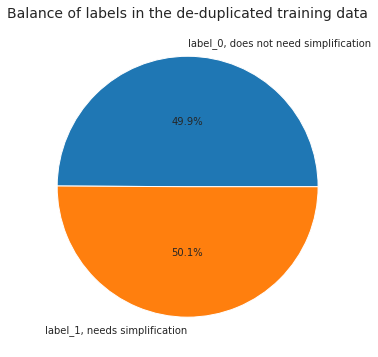

In [ ]:
label_0=len(train_df_new[train_df_new['label']==0])/len(train_df_new)
label_1=len(train_df_new[train_df_new['label']==1])/len(train_df_new)

# Setting up the chating dataframe
df=pd.DataFrame()

df.at[0,'label']='label_0, does not need simplification'
df.at[0,'proportion']=label_0

df.at[1,'label']='label_1, needs simplification'
df.at[1,'proportion']=label_1

pie, ax = plt.subplots(figsize=[10,6])
plt.pie(x=df.proportion, autopct="%.1f%%", labels=df.label, pctdistance=0.5)
plt.title("Balance of labels in the de-duplicated training data", fontsize=14);


INTERPRETATION:

As the new training data is balanced with only 2 labels, we will only focus on accuracy as primary evaluation metric to identify the best feature to take forward

Additionally, for baseline we will only use the uniform random baseline, as most frequent does not make much sense as both binary labels have similar proportion

We will also have a look at F1 score as secondary evaluation metrics 

Let's evaluate Word Frequency in the text 

In [ ]:
# Extracting tokens from the text in the new training data
tokens1=Counter()

for text in tqdm(train_df_new.original_text):
  token=re.findall(r'\w+',text)
  token_a=Counter(token)
  tokens1.update(token_a)



100%|██████████| 300462/300462 [00:08<00:00, 36587.47it/s]


In [ ]:
# Length of the token count
print(len(tokens1))

# Top 50 most common words
top_50 = tokens1.most_common(50)
top_50

158425


[('the', 355238),
 ('of', 211656),
 ('in', 166051),
 ('and', 155422),
 ('a', 136922),
 ('is', 119436),
 ('to', 93713),
 ('RRB', 78610),
 ('LRB', 78474),
 ('The', 63932),
 ('was', 62403),
 ('as', 44248),
 ('for', 39675),
 ('by', 39094),
 ('on', 37404),
 ('with', 30871),
 ('s', 29407),
 ('that', 28067),
 ('from', 27471),
 ('are', 25728),
 ('an', 25405),
 ('or', 23798),
 ('at', 21345),
 ('It', 20282),
 ('his', 18807),
 ('In', 17775),
 ('which', 17530),
 ('it', 16881),
 ('also', 15255),
 ('be', 14435),
 ('has', 14403),
 ('he', 14341),
 ('born', 13861),
 ('first', 13544),
 ('were', 12846),
 ('He', 12444),
 ('one', 11710),
 ('who', 10696),
 ('not', 10491),
 ('France', 10461),
 ('known', 10458),
 ('United', 10400),
 ('have', 10077),
 ('its', 9902),
 ('city', 9649),
 ('1', 9546),
 ('A', 9514),
 ('commune', 9418),
 ('but', 8992),
 ('had', 8704)]

INTERPRETATION

The most frequent words are mostly 'stop words', hence it would make sense to drop these words from the features to reduce feature dimensions

Let's now plot Zipf's law, do the extracted word counts follow this common pattern ? 

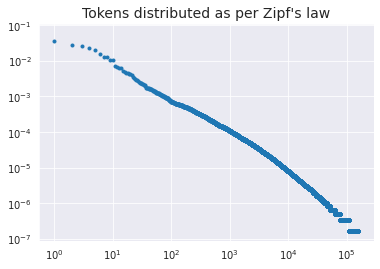

In [ ]:
# Sorting the tokens by counts
sorted_dict=dict(sorted(tokens1.items(), key=lambda item: item[1],reverse=True))


# Creating the dataframe of rank and probability of words
df=pd.DataFrame(sorted_dict,index=['freq'])
df_T=df.T
df_T = df_T.reset_index()
tot=df_T.freq.sum()
df_T['prob']=df_T.freq/tot

# Creating x & y list
x=list(df_T.index)
y=list(df_T.prob)

ax = plt.plot(x, y, '.')
plt.yscale('log')
plt.xscale('log')
plt.title("Tokens distributed as per Zipf's law", fontsize=14);

INTERPRETATION

We see Zipf's law in action in the training text, with a power law distribution indicating very few common words account for most of the tokens, while most other words occur less frequently in the data.




Now, are there any difference between Words associated with each label ?

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


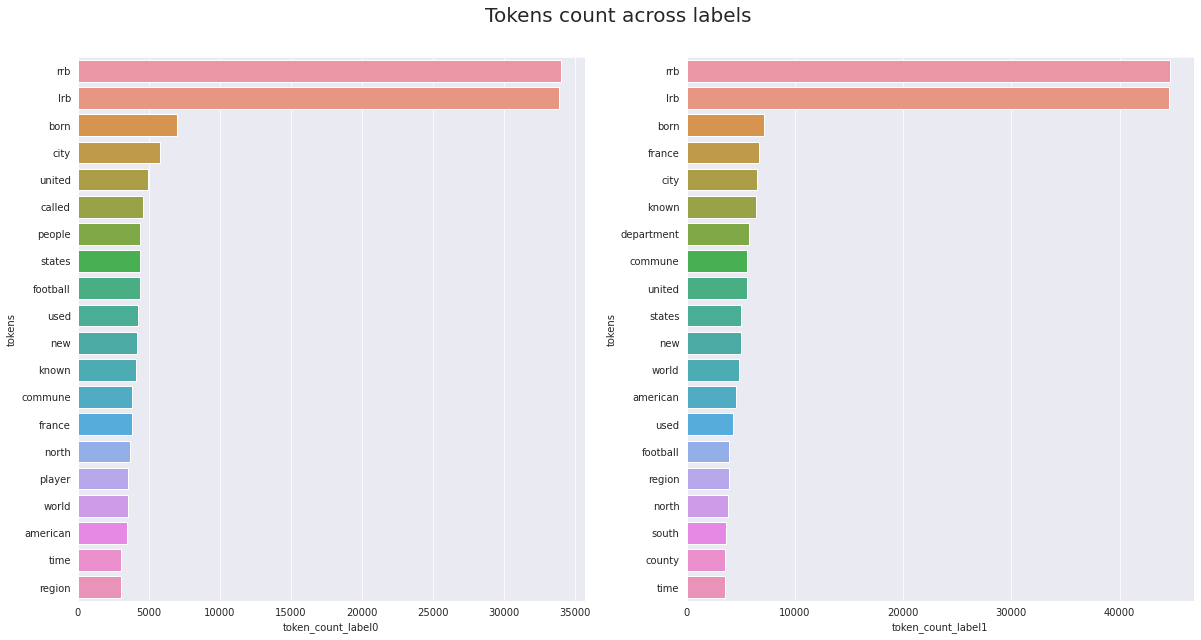

In [ ]:
# Splitting the new training data set as per label values
train_df_new_label0=train_df_new[train_df_new.label==0]
train_df_new_label1=train_df_new[train_df_new.label==1]

# Creating a dataframe of tokens and counts associated with label 0, does NOt NEED simplification
cv_label0=CountVectorizer(stop_words='english') # Only removing the Stop words
X_train_cv_label0=cv_label0.fit_transform(train_df_new_label0.original_text)

df_label0=pd.DataFrame()
df_label0['tokens']=cv_label0.get_feature_names()
# print(len((X_train_cv_label0.sum(axis=0)).tolist()[0]))
df_label0['token_count_label0']=X_train_cv_label0.sum(axis=0).tolist()[0]

# Sorting the dataframe by token_count
df_label0=df_label0.sort_values(by=['token_count_label0'],ascending=False)

df0=df_label0.head(20)




# Creating a dataframe of tokens and counts associated with label 1, does NEED simplification
cv_label1=CountVectorizer(stop_words='english') # Only removing the Stop words
X_train_cv_label1=cv_label1.fit_transform(train_df_new_label1.original_text)

df_label1=pd.DataFrame()
df_label1['tokens']=cv_label1.get_feature_names()
# print(len((X_train_cv_label1.sum(axis=0)).tolist()[0]))
df_label1['token_count_label1']=X_train_cv_label1.sum(axis=0).tolist()[0]

# Sorting the dataframe by token_count
df_label1=df_label1.sort_values(by=['token_count_label1'],ascending=False)

df1=df_label1.head(20)

# 2 Bar plots side by side of top 20 word counts associated with Label 0 and Label 1
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

sns.barplot(data=df0, x='token_count_label0', y='tokens',ax=ax1)
sns.barplot(data=df1, x='token_count_label1', y='tokens',ax=ax2)
plt.suptitle("Tokens count across labels", fontsize=20,x=0.5,y=.95)
plt.show()

INTERPRETATION

The top words associated with label 0 and label 1 seem to be the same. Thus it does not seem that the difference in these high frequency words could have led to the difference in the labels!

The top 2 words associated with both labels are 'lrb' and 'rrb' which indicates start and stop of parentheses in the text and hence do not add much meaning - these can be dropped. We would have to add these 2 words to the default stop word list and then use the augmented Stop Word List.

We will also check whether token count per sentence,  character count and other count metrics per sentence are different across the 2 labels.

Augmenting the default 'english' stop word list with 'lrb' and 'rrb' which stand for parantheses, and while common in the text can be removed as they do not add any meaning as such.

In [ ]:
# Augmenting the default 'english' stop word list to include 'lrb' and 'rrb'
# This augmented stop word list will be used instead of the default 'english' stop word list in 
# the vectorizer definitions
from sklearn.feature_extraction import text

nu_stp_wrds=list(text.ENGLISH_STOP_WORDS.union(["lrb",'rrb']))

print(nu_stp_wrds)

['get', 'via', 'such', 'its', 'what', 'behind', 'their', 'yours', 'nothing', 'through', 'somewhere', 'three', 'whom', 'even', 'two', 'than', 'throughout', 'otherwise', 'have', 'we', 'eg', 'within', 'per', 'on', 'sixty', 'becoming', 'system', 'thence', 'only', 'more', 'move', 'formerly', 'then', 'together', 'also', 'lrb', 'us', 'neither', 'five', 'describe', 'along', 'each', 'enough', 'them', 'empty', 'last', 'serious', 'latter', 'those', 'please', 'other', 'find', 'fifteen', 'some', 'out', 'nowhere', 'who', 'therein', 'inc', 'namely', 'whenever', 'fifty', 'thereafter', 'she', 'am', 'bottom', 'seem', 'further', 'during', 'beside', 'must', 'whole', 'top', 'thus', 'amount', 'your', 'keep', 'again', 'put', 'twelve', 'de', 'often', 'down', 'something', 'next', 'myself', 're', 'how', 'all', 'would', 'mill', 'beforehand', 'another', 'around', 'about', 'hereupon', 'everything', 'could', 'whether', 'our', 'except', 'someone', 'so', 'cannot', 'with', 'had', 'will', 'done', 'elsewhere', 'if', 'an

Checking whether character counts / token counts/ average char counts per token/ char count of largest token per sentence are similar (or not) between the 2 labels

In [ ]:
# How much NaN is present in the wordcount features


df=pd.DataFrame(columns=['col_name','NAN_count'])
for idx,val in enumerate(word_count_list):
  df.at[idx,'col_name']=str(val)
  df.at[idx,'NAN_count']=len(train_df_new)-train_df_new[val].count()



print(df)

            col_name NAN_count
0    smpl_char_count         0
1     smpl_tkn_count         0
2  avg_chars_per_tkn         0
3    chars_lrgst_tkn         0


INTERPRETATION

No NaNs present in the word_count_list features

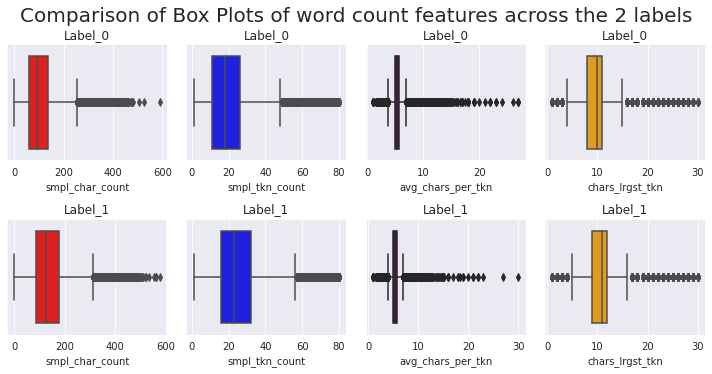

In [ ]:
# list of variables for which we will plot the Box plot across 2 label categories
# to explore the difference

col_list=['smpl_char_count','smpl_tkn_count','avg_chars_per_tkn','chars_lrgst_tkn']

# Setting up the subplots
fig, ((ax1, ax2,ax3,ax4),
      (ax5,ax6, ax7,ax8),
      ) = plt.subplots(2, 4,figsize=(10,5))

# Title for the whole plot
fig.suptitle('Comparison of Box Plots of word count features across the 2 labels',fontsize=20,x=0.5,y=1.03)

# List of axis items

axis_box0=[ax1,ax2,ax3,ax4,
          ]

axis_box1=[ax5, ax6,ax7,ax8
]


#list of histogram colors
colors=['red','blue','purple','orange','brown','green','navy','olive']

for idx,val in enumerate(col_list):
  name=str(val)
  sns.boxplot(x=train_df_new_label0[name],ax=axis_box0[idx],color=colors[idx])
  axis_box0[idx].set_title('Label_0')

for idx,val in enumerate(col_list):
  name=str(val)
  sns.boxplot(x=train_df_new_label1[name],ax=axis_box1[idx],color=colors[idx])
  axis_box1[idx].set_title('Label_1')

    

#Show Plot
fig.tight_layout()
plt.show();

INTERPRETATION 

The 4 categories of word counts show a slightly higher values for Label 1 -indicating that there is possibility of using these as features to predict the labels. These could be due to the fact that the Label 1 text (text which needs to be simplified) uses longer words, more word per sentence or more Parts of speech for a richer sentence structure which could make it difficult to understand for someone with a limited vocabulary. 

We will check later if we can use the 4 features to predict the label -how accurate will it be ?

Only Plotting the means of count of the 4 word count variables to see their difference side by side

    token_char_label            variable average_count
0    smpl_char_count  label_0_mean_count       103.385
1     smpl_tkn_count  label_0_mean_count       19.5217
2  avg_chars_per_tkn  label_0_mean_count       5.36739
3    chars_lrgst_tkn  label_0_mean_count       9.97451
4    smpl_char_count  label_1_mean_count        138.24


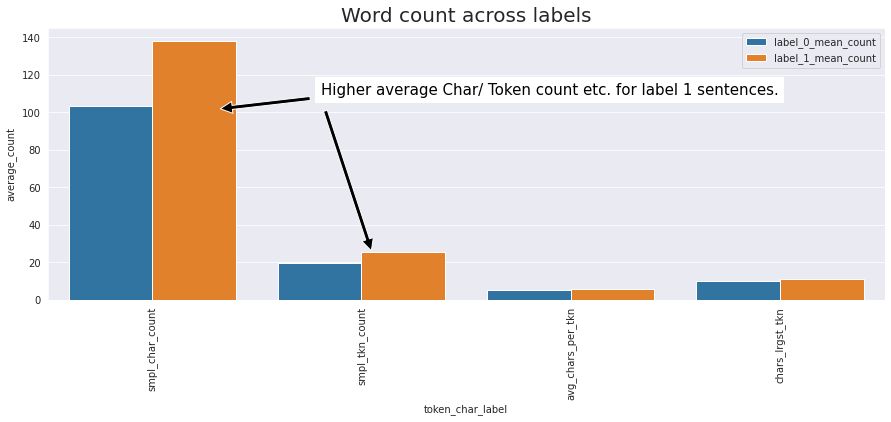

In [ ]:
# Identifying the POS tag count columns
# col_list=list(train_df_new_label0.columns[2:6])
# print(col_list)
word_count_list
df=pd.DataFrame(columns=['token_char_label','label_0_mean_count','label_1_mean_count'])

for idx,val in enumerate(word_count_list):
  df.at[idx,'token_char_label']=str(val)
  df.at[idx,'label_0_mean_count']=train_df_new_label0[val].mean()
  df.at[idx,'label_1_mean_count']=train_df_new_label1[val].mean()

# melting the dataframe to be used as in barplot
melt_df=pd.melt(df,id_vars=['token_char_label'],value_vars=['label_0_mean_count','label_1_mean_count'],
                var_name ='variable', value_name ='average_count')
print(melt_df.head())

# Barplot visualization
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()

ax=sns.barplot(x='token_char_label', y='average_count', hue='variable', data=melt_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Annotation
ax.annotate('Higher average Char/ Token count etc. for label 1 sentences.',
                    color="black",fontsize=15, #fontweight='bold',
                     xy=(0.2, 0.7),  xycoords='axes fraction',
                    xytext=(.6, 0.8), textcoords='axes fraction',
                    arrowprops=dict(facecolor='k', shrink=0.05),
                    horizontalalignment='center', verticalalignment='top',
                    bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="w", lw=2)
                    )

ax.annotate('Higher average Char/ Token count etc. for label 1 sentences.',
                    color="black",fontsize=15, #fontweight='bold',
                     xy=(0.39, 0.15),  xycoords='axes fraction',
                    xytext=(.6, 0.8), textcoords='axes fraction',
                    arrowprops=dict(facecolor='k', shrink=0.05),
                    horizontalalignment='center', verticalalignment='top',
                    bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="w", lw=2)
                    )


plt.legend()
plt.title("Word count across labels", fontsize=20);
plt.show()

INTERPRETATION

We also find that character counts and even token counts are  higher for Label 1.

Thus we can use these as a feature to predict simplicity labels.



Checking whether POS tag counts per sentence are similar (or not) between the 2 labels

In [ ]:
# How much NaN is present in the pos count features



df=pd.DataFrame(columns=['col_name','NAN_count'])
for idx,val in enumerate(pos_tag_count_list):
  df.at[idx,'col_name']=str(val)
  df.at[idx,'NAN_count']=len(train_df_new)-train_df_new[val].count()



print(df)

   col_name NAN_count
0        EX         0
1       VBZ         0
2        JJ         0
3        NN         0
4       WDT         0
5       NNP         0
6       VBD         0
7        TO         0
8        VB         0
9        IN         0
10       DT         0
11      NNS         0
12       RB         0
13       CD         0
14       ''         0
15        ,         0
16       CC         0
17     PRP$         0
18        .         0
19      POS         0
20      VBN         0
21       WP         0
22      PRP         0
23      VBG         0
24      VBP         0
25        :         0
26      RBS         0
27      WRB         0
28      JJS         0
29      JJR         0
30       MD         0
31       RP         0
32     NNPS         0
33      RBR         0
34       FW         0
35      WP$         0
36       ``         0
37        $         0
38        #         0
39      PDT         0
40      SYM         0
41       UH         0
42       LS         0


INTERPRETATION

No NaNs present in the pos_tag_count_list feature

  POS_tag            variable average_POS_tag_count
0      EX  label_0_mean_count             0.0227311
1     VBZ  label_0_mean_count              0.583279
2      JJ  label_0_mean_count               1.12395
3      NN  label_0_mean_count               2.54909
4     WDT  label_0_mean_count             0.0817291


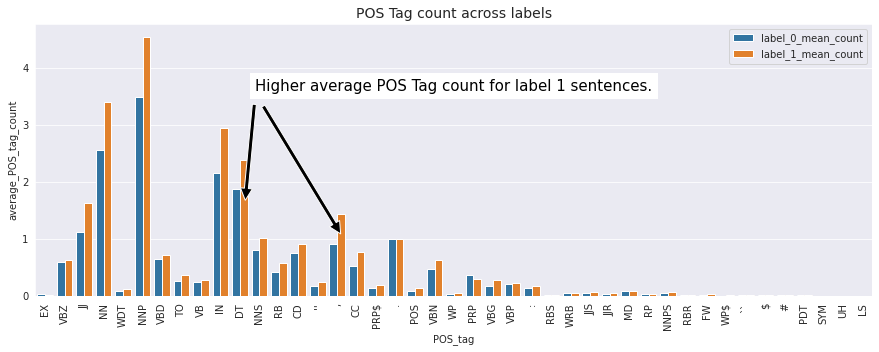

In [ ]:
# Identifying the POS tag count columns
# col_list=list(train_df_new_label0.columns[6:48])
# print(col_list)

pos_tag_count_list

df=pd.DataFrame(columns=['POS_tag','label_0_mean_count','label_1_mean_count'])

for idx,val in enumerate(pos_tag_count_list):
  df.at[idx,'POS_tag']=str(val)
  df.at[idx,'label_0_mean_count']=train_df_new_label0[val].mean()
  df.at[idx,'label_1_mean_count']=train_df_new_label1[val].mean()

# melting the dataframe to be used as in barplot
melt_df=pd.melt(df,id_vars=['POS_tag'],value_vars=['label_0_mean_count','label_1_mean_count'],
                var_name ='variable', value_name ='average_POS_tag_count')
print(melt_df.head())

# Barplot visualization
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()

ax=sns.barplot(x='POS_tag', y='average_POS_tag_count', hue='variable', data=melt_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Annotation
ax.annotate('Higher average POS Tag count for label 1 sentences.',
                    color="black",fontsize=15, #fontweight='bold',
                     xy=(0.25, 0.33),  xycoords='axes fraction',
                    xytext=(.5, 0.8), textcoords='axes fraction',
                    arrowprops=dict(facecolor='k', shrink=0.05),
                    horizontalalignment='center', verticalalignment='top',
                    bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="w", lw=2)
                    )

ax.annotate('Higher average POS Tag count for label 1 sentences.',
                    color="black",fontsize=15, #fontweight='bold',
                     xy=(0.37, 0.2),  xycoords='axes fraction',
                    xytext=(.5, 0.8), textcoords='axes fraction',
                    arrowprops=dict(facecolor='k', shrink=0.05),
                    horizontalalignment='center', verticalalignment='top',
                    bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="w", lw=2)
                    )


plt.legend()
plt.title("POS Tag count across labels", fontsize=14);
plt.show()

INTERPRETATION

We also find that Average POS Tag counts are slightly higher for Label 1, across multiple POS tags. This could indicate that Label 1 text (which needs to be simplified) has a more complex grammatical structure with different kinds of parts of speech to possibly deliver a richer meaning, but which also ends up making it more difficult to understand. 

Thus we can use these as a feature to predict simplicity labels.



# 6.Feature Generation

This will have the following 7 sets of features:
1. Word and Token counts
2. POS Tag counts
3. Combined Word/ Token & POS Tag counts
4. 3 Options of Word Vectorizer
5. 3 Options of Tfids Vectorizer
6. A word2vec option with 100 dims
7. NER Features 
8. Most diffenetiating 4 NER Features+ AoA

Feature Generation options 1,2,3

In [ ]:
%%time

with joblib.parallel_backend('dask'):
  col_list1=word_count_list
  col_list2=pos_tag_count_list
  col_list3=word_count_list+pos_tag_count_list



  # word_count_list=col_lst[2:6]
  # pos_tag_count_list=col_lst[6:49]
  # LDA_list=col_lst[49:59]
  # LSI_list=col_lst[59:77]
  # NER_list=col_lst[78:97]
  # Other_complexity_list=col_lst[97:-1]


  train_df_new,dev_df

  X_train_wc1=np.array(train_df_new[col_list1])
  y_train=list(train_df_new.label)
  X_dev_wc1=np.array(dev_df[col_list1])
  y_dev=list(dev_df.label)
  X_test_wc1=np.array(test_df_1[col_list1])
  y_test=list(test_df_1.label)


  X_train_wc2=np.array(train_df_new[col_list2])
  X_dev_wc2=np.array(dev_df[col_list2])
  X_test_wc2=np.array(test_df_1[col_list2])

  X_train_wc3=np.array(train_df_new[col_list3])
  X_dev_wc3=np.array(dev_df[col_list3])
  X_test_wc3=np.array(test_df_1[col_list3])



  print(X_train_wc1)

[[ 62.          11.           5.63636364   9.        ]
 [110.          23.           4.7826087    8.        ]
 [ 70.          14.           5.           9.        ]
 ...
 [141.          27.           5.22222222  10.        ]
 [ 89.          16.           5.5625      10.        ]
 [105.          21.           5.           9.        ]]
CPU times: user 254 ms, sys: 159 ms, total: 414 ms
Wall time: 397 ms


Feature generation options 4 & 5 -these would have hyperparameters like min_df, ngram range which can be tuned

In [ ]:
%%time
def vect_to_acc(vect,min_df,stop_words,ngram_range,lower_case):
  if vect=='CountVectorizer':
    model=CountVectorizer(min_df=min_df,stop_words=stop_words,
                          ngram_range=ngram_range,lowercase=lower_case)
  elif vect=='TfidfVectorizer':
    model=TfidfVectorizer(min_df=min_df,stop_words=stop_words,
                          ngram_range=ngram_range,lowercase=lower_case)

  X_train=model.fit_transform(train_df_new.original_text)
  # y_train = list(train_df_new.label)
  
  X_dev=model.transform(dev_df.original_text)
  # y_dev=list(dev_df.label)

  X_test=model.transform(test_df_1.original_text)
  # y_dev=list(dev_df.label)


  
  return X_train,X_dev,X_test
 

wc_1=vect_to_acc(vect='CountVectorizer',min_df=5,
                    stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True)
wc_2=vect_to_acc(vect='CountVectorizer',min_df=10000,
                    stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True)
wc_3=vect_to_acc(vect='CountVectorizer',min_df=5,
                    stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True)


tfidf_1=vect_to_acc(vect='TfidfVectorizer',min_df=5,
                    stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True)
tfidf_2=vect_to_acc(vect='TfidfVectorizer',min_df=10000,
                    stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=False)
tfidf_3=vect_to_acc(vect='TfidfVectorizer',min_df=5,
                    stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True)


CPU times: user 1min 16s, sys: 974 ms, total: 1min 17s
Wall time: 1min 17s


Feature Generation option 6 using word2vec

In [ ]:
%%time

with joblib.parallel_backend('dask'):
  # Tokenizing the text
  re_tokenized_text=[]
  for t in tqdm(train_df_new.original_text):
      t=t.lower()
      tokens=re.findall(r'\w+',t)
      re_tokenized_text.append(tokens)

  # Search for word2vec model pickle object, only if it does not exist should you run the model 
  # if os.path.exists("/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/word2vec_model_dict.pickle"):
  #   print('\n Word2Vec Pickle Object already exists at :/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/word2vec_model_dict.pickle')

  # else:
  word2vec_model = Word2Vec(sentences=re_tokenized_text, 
                            size=100,
                            window=2,
                            min_count=100,
                            workers=4,
                            seed=RANDOM_SEED)

  # word2vec_model.save("word2vec_model.model")

  word2vec_model_dict={'word2vec_model_dict':word2vec_model}

  # Saving the keyed vectors word2vec model as pickle object
  pickle_out = open("/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/word2vec_model_dict.pickle","wb")
  pickle.dump(word2vec_model_dict, pickle_out)
  pickle_out.close()
    
  quick_word_vectors = word2vec_model.wv
  quick_word_vectors.similar_by_word("an")[:10]


100%|██████████| 300462/300462 [00:03<00:00, 85843.34it/s]


CPU times: user 1min 6s, sys: 772 ms, total: 1min 7s
Wall time: 39.7 s


In [ ]:
# Loading the saved word2vec model for classification using a dense vector approach

pickle_in = open("/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/word2vec_model_dict.pickle","rb")
loaded_dict = pickle.load(pickle_in)
pickle_in.close()

print(loaded_dict.keys())
model_wp=loaded_dict['word2vec_model_dict']

dict_keys(['word2vec_model_dict'])


In [ ]:
%%time

with joblib.parallel_backend('dask'):

  # Tokenizing the training text, also removing stop words
  tokenized_train_items=[]
  for t in tqdm(train_df_new.original_text):
      t=t.lower()
      tokens=re.findall(r'\w+',t)
      tokens=[w for w in tokens if not w.lower() in nu_stp_wrds]
      tokenized_train_items.append(tokens)

  def generate_dense_features(tokenized_texts, word_vectors): 
      train_list=[]
      for toknzd_doc in tqdm(tokenized_texts):
          # skipping words in tokens which are not in vocab of word vector
          words = [w for w in toknzd_doc if w in word_vectors.wv.vocab]
          
          if len(words)>0:
              word_mean=np.mean(word_vectors[words],axis=0)
          else:
              word_mean=np.zeros(word_vectors.vector_size)
              
          train_list.append(word_mean)
          
      return np.array(train_list)

  X_train_w2v = generate_dense_features(tokenized_train_items, model_wp)
  # Checking shape of X_train_w2v
  print(X_train_w2v.shape)


100%|██████████| 300462/300462 [00:20<00:00, 14363.61it/s]


(300462, 100)
CPU times: user 54.9 s, sys: 1.93 s, total: 56.8 s
Wall time: 55.7 s


Dev version of word2vec feature

In [ ]:
%%time

with joblib.parallel_backend('dask'):
  # Generate dev data
  tokenized_dev_items = []
  for t in tqdm(dev_df.original_text):
      t=t.lower()
      tokens=re.findall(r'\w+',t)
      tokens=[w for w in tokens if not w.lower() in nu_stp_wrds]
      tokenized_dev_items.append(tokens)

  X_dev_w2v = generate_dense_features(tokenized_dev_items, model_wp)
  # Checking shape of X_dev_w2v
  print(X_dev_w2v.shape)


100%|██████████| 46894/46894 [00:03<00:00, 13991.65it/s]


(46894, 100)
CPU times: user 9.36 s, sys: 331 ms, total: 9.69 s
Wall time: 9.48 s


Test version of word2vec feature

In [ ]:
%%time

with joblib.parallel_backend('dask'):
  # Generate test data
  tokenized_test_items = []
  for t in tqdm(test_df_1.original_text):
      t=t.lower()
      tokens=re.findall(r'\w+',t)
      tokens=[w for w in tokens if not w.lower() in nu_stp_wrds]
      tokenized_test_items.append(tokens)

  X_test_w2v = generate_dense_features(tokenized_test_items, model_wp)
  # Checking shape of X_test_w2v
  print(X_test_w2v.shape)

100%|██████████| 119092/119092 [00:08<00:00, 14658.63it/s]


(119092, 100)
CPU times: user 21 s, sys: 745 ms, total: 21.7 s
Wall time: 21.2 s


Feature 7 -train, dev & test

In [ ]:

X_train_ner=np.array(train_df_ner)
X_dev_ner=np.array(dev_df_ner)
X_test_ner=np.array(test_df_ner)

Feature 8 -train, dev & test

In [ ]:
X_train_ner_aoa=np.array(train_df_ner_aoa)
X_dev_ner_aoa=np.array(dev_df_ner_aoa)
X_test_ner_aoa=np.array(test_df_ner_aoa)

# 7.Logistic Regression classification using the above feature sets

This will additionally have a baseline dummy prediction

We will plot Training Set accuracy and dev accuracy to identify best performing feature sets.



In [ ]:
%%time

with joblib.parallel_backend('dask'):

  # The 2 baseline predictions and their Training set accuracy and F1 score
  # Fitting dummy classifier with strategy=uniform
  cv=CountVectorizer(min_df=50000,stop_words='english') 
  X_train_cv1=cv.fit_transform(train_df_new.original_text)
  # y_train = list(train_df_new.label)

  # print(X_train_cv1.shape[1])

  X_dev_cv1=cv.transform(dev_df.original_text)
  # y_dev = list(dev_df.label)

  dummy_clf_uniform=DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)
  dummy_clf_uniform.fit(X_train_cv1[:10000,:],y_train[:10000])

  # Fitting dummy classifier with strategy=most_freq
  dummy_clf_most_freq=DummyClassifier(strategy="most_frequent",random_state=RANDOM_SEED)
  dummy_clf_most_freq.fit(X_train_cv1[:10000,:],y_train[:10000])

  # Creating the predicted label for the  2 dummy classifier 
  rand_train_preds=dummy_clf_uniform.predict(X_train_cv1)
  rand_dev_preds=dummy_clf_uniform.predict(X_dev_cv1)
  




  mf_train_preds=dummy_clf_most_freq.predict(X_train_cv1)

  # Computing accuracy for the 2 dummy classifier
  rand_train_acc=accuracy_score(y_train, rand_train_preds)
  rand_dev_acc=accuracy_score(y_dev, rand_dev_preds)

  mf_train_acc=accuracy_score(y_train, mf_train_preds)

  # Computing f1 score, precision, recall for the 2 dummy classifier 
  rand_train_f1=f1_score(y_train, rand_train_preds)
  rand_dev_f1=f1_score(y_dev, rand_dev_preds)

  mf_train_f1=f1_score(y_train, mf_train_preds)

  rand_train_precision=precision_score(y_train, rand_train_preds)
  mf_train_precision=precision_score(y_train, mf_train_preds)

  rand_train_recall=recall_score(y_train, rand_train_preds)
  mf_train_recall=recall_score(y_train, mf_train_preds)

  print('f1',rand_train_f1,mf_train_f1)
  print('precision',rand_train_precision,mf_train_precision)
  print('recall',rand_train_recall,mf_train_recall)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 0.4995052259468177 0.0
precision 0.5009154938989349 0.0
recall 0.4981028765839818 0.0
CPU times: user 9.27 s, sys: 181 ms, total: 9.46 s
Wall time: 9.38 s


                  model_type dimensions  ... training_precision training_recall
0  uniformly_random_baseline          2  ...           0.500915        0.498103

[1 rows x 6 columns]
   training_acc training_f1
0      0.500047    0.499505
1      0.614354    0.591989
2      0.626282    0.599069
3      0.641762    0.621632
4      0.728811    0.716779
5       0.51707     0.20098
6      0.792157    0.785569
7        0.7076    0.702824
8      0.544618    0.515181
9      0.741628    0.738557
10     0.579098    0.589043


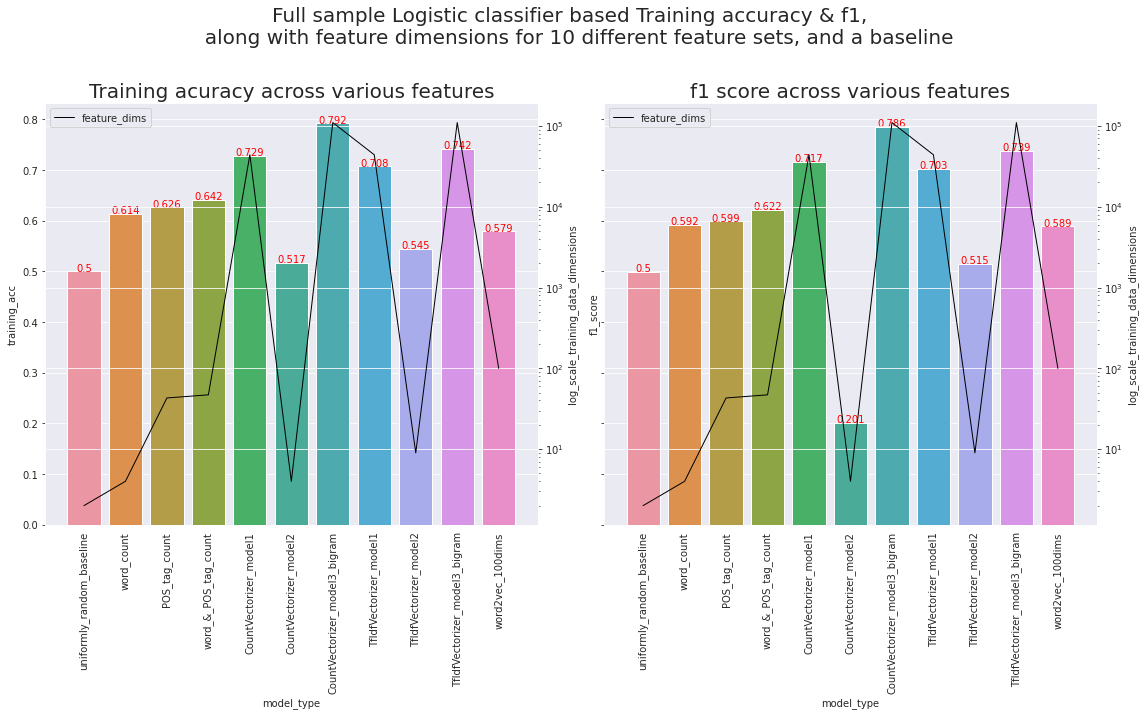

CPU times: user 4min 27s, sys: 3min 11s, total: 7min 38s
Wall time: 4min


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  # Automated approach for basic logistic regression classifier

  X_Train_list=[X_train_wc1,X_train_wc2,X_train_wc3,
                wc_1[0],wc_2[0],wc_3[0],
                tfidf_1[0],tfidf_2[0],tfidf_3[0],
                X_train_w2v,
                # X_train_ner,
                # X_train_ner_aoa,
                ]
  X_dev_list=[X_dev_wc1,X_dev_wc2,X_dev_wc3,
              wc_1[1],wc_2[1],wc_3[1],
              tfidf_1[1],tfidf_2[1],tfidf_3[1],
              X_dev_w2v,
              # X_dev_ner,
              # X_dev_ner_aoa,
              ]

  # X_test_list=[X_test_wc1,X_test_wc2,X_test_wc3,
  #             wc_1[2],wc_2[2],wc_3[2],
  #             tfidf_1[2],tfidf_2[2],tfidf_3[2],
  #             X_test_w2v,
  #             # X_test_7 ,
  #             ]

  # model_defn=['word_count','POS_tag_count','word_&_POS_tag_count',
  #             "vect='CountVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True",
  #             "vect='CountVectorizer',min_df=10000,stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True",
  #             "vect='CountVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #             "vect='TfIdfVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True",
  #             "vect='TfIdfVectorizer',min_df=10000,stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True",
  #             "vect='TfIdfVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #           'word2vec_100dims',
  #           'NER_feature',
  #           'NER_AoA_feature',
  #           ]


  model_defn=['word_count','POS_tag_count','word_&_POS_tag_count',
              "CountVectorizer_model1",
              "CountVectorizer_model2",
              "CountVectorizer_model3_bigram",
              "TfIdfVectorizer_model1",
              "TfIdfVectorizer_model2",
              "TfIdfVectorizer_model3_bigram",
            'word2vec_100dims',
            # 'NER_feature',
            # 'NER_AoA_feature',
            ]

  # Logistic regression based Training set accuracy and f1 score
  df=pd.DataFrame(columns=['model_type','dimensions','training_acc','training_f1',
                          'training_precision','training_recall'])
  df.at[0,'model_type']='uniformly_random_baseline'
  df.at[0,'dimensions']=X_dev_cv1.shape[1]
  df.at[0,'training_acc']=rand_train_acc
  df.at[0,'training_f1']=rand_train_f1
  df.at[0,'training_precision']=rand_train_precision
  df.at[0,'training_recall']=rand_train_recall

  # df.at[1,'model_type']='most_freq_baseline'
  # df.at[1,'dimensions']=X_dev_cv1.shape[1]
  # df.at[1,'training_acc']=mf_train_acc
  # df.at[1,'training_f1']=mf_train_f1
  # df.at[1,'training_precision']=mf_train_precision
  # df.at[1,'training_recall']=mf_train_recall

  print(df.head())

  clf=LogisticRegression(random_state=RANDOM_SEED,solver='lbfgs',max_iter=10000)
  for i in range(10): 
    X_train=X_Train_list[i]
    X_dev=X_dev_list[i]
    model_name=model_defn[i]

    clf.fit(X_train[:,:],y_train[:])

    lr_train_preds=clf.predict(X_train)
    lr_train_acc=accuracy_score(y_train, lr_train_preds)
    lr_train_f1=f1_score(y_train, lr_train_preds)
    lr_train_precision=precision_score(y_train, lr_train_preds)
    lr_train_recall=recall_score(y_train, lr_train_preds)

    df.at[i+1,'model_type']=model_name
    df.at[i+1,'dimensions']=X_train.shape[1]
    df.at[i+1,'training_acc']=lr_train_acc
    df.at[i+1,'training_f1']=lr_train_f1
    df.at[i+1,'training_precision']=lr_train_precision
    df.at[i+1,'training_recall']=lr_train_recall

  print(df[['training_acc','training_f1']])

  # Plotting accuracy
  fig, (ax1, ax2)= plt.subplots(1, 2,figsize=(16,9),sharey=True)

  fig.suptitle('Full sample Logistic classifier based Training accuracy & f1, \n\
  along with feature dimensions for 10 different feature sets, and a baseline',fontsize=20,x=0.5,y=1.1)


  sns.barplot(data=df, x='model_type', y='training_acc',ax=ax1)
  ax1.set_xticklabels(df['model_type'], rotation=90)
  # ax1.set_xlabel('model_type',fontsize=15)
  ax1.set_ylabel('training_acc',fontsize=10)
  ax1.set_title('Training acuracy across various features',fontsize=20)

  # Plotting the twin y axis for dimensions
  axes2 = ax1.twinx()
  axes2.set_yscale('log')
  line1=axes2.plot(df['model_type'],df['dimensions'],'black',linewidth=1,label="feature_dims")
  axes2.set_ylabel('log_scale_training_data_dimensions',fontsize=10)

  # Showing the labels in the barplot
  for index, row in df.iterrows():
    ax1.text(row.name,row.training_acc, round(row.training_acc,3), color='red', ha="center")

  plt.legend()

  sns.barplot(data=df, x='model_type', y='training_f1',ax=ax2)
  ax2.set_xticklabels(df['model_type'], rotation=90)
  ax2.set_xlabel('model_type',fontsize=10)
  ax2.set_ylabel('f1_score',fontsize=10)
  ax2.set_title('f1 score across various features',fontsize=20)

  # Plotting the twin y axis for dimensions
  axes2 = ax2.twinx()
  axes2.set_yscale('log')
  line1=axes2.plot(df['model_type'],df['dimensions'],'black',linewidth=1,label="feature_dims")
  axes2.set_ylabel('log_scale_training_data_dimensions',fontsize=10)

  # Showing the labels in the barplot
  for index, row in df.iterrows():
    ax2.text(row.name,row.training_f1, round(row.training_f1,3), color='red', ha="center")


  fig.tight_layout()
  plt.legend()
  plt.show()




0.6202712500533117 0.5970993506346585 {0, 1} {0, 1}
0.6294408666353905 0.601728129082533 {0, 1} {0, 1}
0.6475668529022903 0.628147148160648 {0, 1} {0, 1}
0.6396127436345801 0.6189574314574315 {0, 1} {0, 1}
0.5179767134388195 0.1990645595634611 {0, 1} {0, 1}
0.6342175971339618 0.6178796587137161 {0, 1} {0, 1}
0.6468204887618885 0.6401442725534504 {0, 1} {0, 1}
0.5469356420864077 0.5166969972702457 {0, 1} {0, 1}
0.6485051392502239 0.6459760733692733 {0, 1} {0, 1}
0.5794771186079243 0.5898673100120626 {0, 1} {0, 1}
  training_acc training_f1   dev_acc    dev_f1
0     0.614354    0.591989  0.620271  0.597099
1     0.626282    0.599069  0.629441  0.601728
2     0.641762    0.621632  0.647567  0.628147
3     0.728811    0.716779  0.639613  0.618957
4      0.51707     0.20098  0.517977  0.199065
5     0.792157    0.785569  0.634218   0.61788
6       0.7076    0.702824  0.646820  0.640144
7     0.544618    0.515181  0.546936  0.516697
8     0.741628    0.738557  0.648505  0.645976
9     0.5790

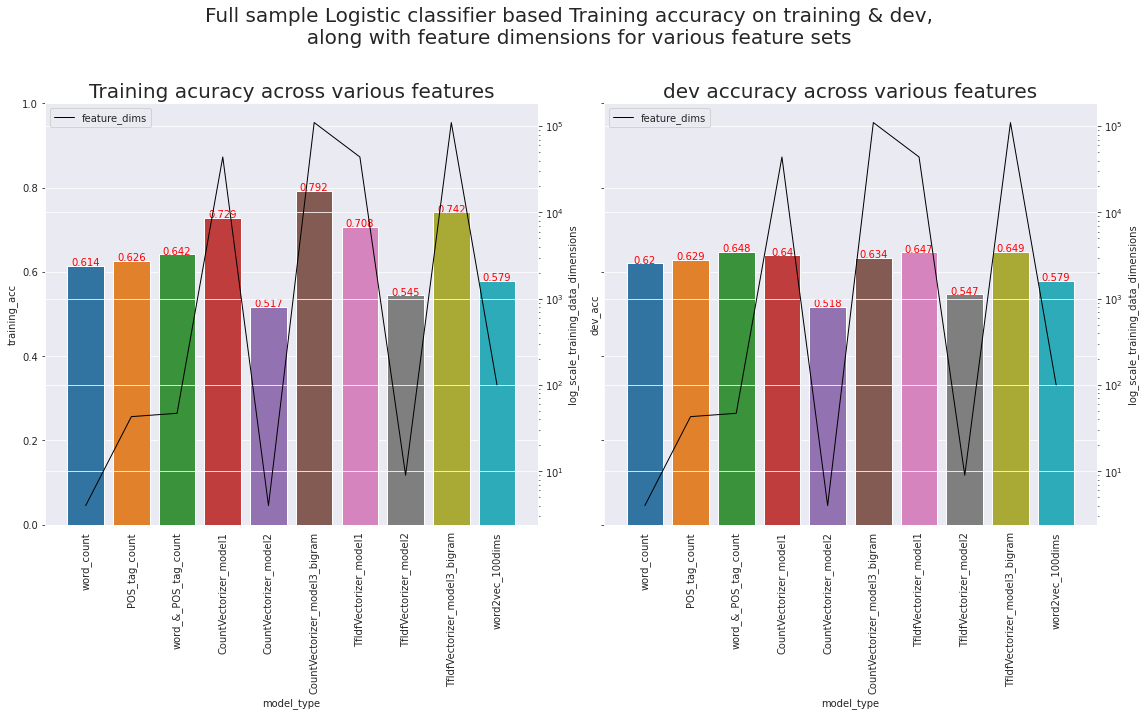

CPU times: user 4min 22s, sys: 3min 12s, total: 7min 35s
Wall time: 3min 57s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  # Automated approach for basic logistic regression classifier

  X_Train_list=[X_train_wc1,X_train_wc2,X_train_wc3,
                wc_1[0],wc_2[0],wc_3[0],
                tfidf_1[0],tfidf_2[0],tfidf_3[0],
                X_train_w2v,
                # X_train_ner,
                # X_train_ner_aoa,
                ]
  X_dev_list=[X_dev_wc1,X_dev_wc2,X_dev_wc3,
              wc_1[1],wc_2[1],wc_3[1],
              tfidf_1[1],tfidf_2[1],tfidf_3[1],
              X_dev_w2v,
              # X_dev_ner,
              # X_dev_ner_aoa,
              ]
  # X_test_list=[X_test_wc1,X_test_wc2,X_test_wc3,
  #             wc_1[2],wc_2[2],wc_3[2],
  #             tfidf_1[2],tfidf_2[2],tfidf_3[2],
  #             X_test_w2v,
  #             # X_test_7 ,
  #             ]

  # model_defn=['word_count','POS_tag_count','word_&_POS_tag_count',
  #             "vect='CountVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True",
  #             "vect='CountVectorizer',min_df=10000,stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True",
  #             "vect='CountVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #             "vect='TfIdfVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True",
  #             "vect='TfIdfVectorizer',min_df=10000,stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True",
  #             "vect='TfIdfVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #           'word2vec_100dims',
  #           'NER_feature',
  #           'NER_AoA_feature',
  #           ]

  model_defn=['word_count','POS_tag_count','word_&_POS_tag_count',
              "CountVectorizer_model1",
              "CountVectorizer_model2",
              "CountVectorizer_model3_bigram",
              "TfIdfVectorizer_model1",
              "TfIdfVectorizer_model2",
              "TfIdfVectorizer_model3_bigram",
            'word2vec_100dims',
            # 'NER_feature',
            # 'NER_AoA_feature',
            ]


  # model_defn=['POS_tag_count','word_&_POS_tag_count',
  #             "CountVectorizer_model3_bigram",
  #             "TfIdfVectorizer_model3_bigram",
            
  #           ]

  # Logistic regression based Training set accuracy and f1 score
  # Benoulli NB based Training set accuracy and f1 score
  df=pd.DataFrame(columns=['model_type','dimensions','training_acc','training_f1',
                          'dev_accuracy','dev_f1'])


  df.at[0,'model_type']='uniformly_random_baseline'
  df.at[0,'dimensions']=X_dev_cv1.shape[1]
  df.at[0,'training_acc']=rand_train_acc
  df.at[0,'training_f1']=rand_train_f1
  df.at[0,'dev_accuracy']=rand_dev_acc
  df.at[0,'dev_f1']=rand_dev_f1



  nbclf=LogisticRegression(random_state=RANDOM_SEED,solver='lbfgs',max_iter=20000)
  for i in range(10):
    X_train=X_Train_list[i]
    X_dev=X_dev_list[i]
    model_name=model_defn[i]
    
    nbclf.fit(X_train[:,:],y_train[:])

    nb_train_preds=nbclf.predict(X_train)
    nb_train_acc=accuracy_score(y_train, nb_train_preds)
    # print('y_train.shape -->',len(y_train),'nb_train_preds.shape -->', nb_train_preds.shape)
    nb_train_f1=f1_score(y_train, nb_train_preds)

    nb_dev_preds=nbclf.predict(X_dev)
    nb_dev_acc=accuracy_score(y_dev, nb_dev_preds)
    # print('y_dev.shape -->',len(y_dev),'nb_dev_preds.shape -->', nb_dev_preds.shape)
    nb_dev_f1=f1_score(y_dev, nb_dev_preds)
    print(nb_dev_acc,nb_dev_f1,set(y_dev),set(nb_dev_preds))
    

    df.at[i,'model_type']=model_name
    df.at[i,'dimensions']=X_train.shape[1]
    df.at[i,'training_acc']=nb_train_acc
    df.at[i,'training_f1']=nb_train_f1
    df.at[i,'dev_acc']=nb_dev_acc
    df.at[i,'dev_f1']=nb_dev_f1
    

  print(df[['training_acc','training_f1','dev_acc','dev_f1']])

  # Plotting accuracy
  fig, (ax1, ax2)= plt.subplots(1, 2,sharey=True,figsize=(16,9))

  fig.suptitle('Full sample Logistic classifier based Training accuracy on training & dev, \n\
  along with feature dimensions for various feature sets',fontsize=20,x=0.5,y=1.1)


  sns.barplot(data=df, x='model_type', y='training_acc',ax=ax1)
  ax1.set_xticklabels(df['model_type'], rotation=90)
  # ax1.set_xlabel('model_type',fontsize=15)
  ax1.set_ylabel('training_acc',fontsize=10)
  ax1.set_title('Training acuracy across various features',fontsize=20)

  ax1.set_ylim(0, 1)

  # Plotting the twin y axis for dimensions
  axes2 = ax1.twinx()
  axes2.set_yscale('log')
  line1=axes2.plot(df['model_type'],df['dimensions'],'black',linewidth=1,label="feature_dims")
  axes2.set_ylabel('log_scale_training_data_dimensions',fontsize=10)

  # Showing the labels in the barplot
  for index, row in df.iterrows():
    ax1.text(row.name,row.training_acc, round(row.training_acc,3), color='red', ha="center")

  plt.legend()

  sns.barplot(data=df, x='model_type', y='dev_acc',ax=ax2)
  ax2.set_xticklabels(df['model_type'], rotation=90)
  ax2.set_xlabel('model_type',fontsize=10)
  ax2.set_ylabel('dev_acc',fontsize=10)
  ax2.set_title('dev accuracy across various features',fontsize=20)

  # Plotting the twin y axis for dimensions
  axes2 = ax2.twinx()
  axes2.set_yscale('log')
  line1=axes2.plot(df['model_type'],df['dimensions'],'black',linewidth=1,label="feature_dims")
  axes2.set_ylabel('log_scale_training_data_dimensions',fontsize=10)

  # Showing the labels in the barplot
  for index, row in df.iterrows():
    ax2.text(row.name,row.dev_acc, round(row.dev_acc,3), color='red', ha="center")

  plt.legend()

  fig.tight_layout()
  plt.show()



INTERPRETATION

From the perspective of higher training accuracy & dev accuracy and lower dimensions to allow quicker computation, we would select the following models 
1. word & pos tag count
2. pos tag count
3. count_vector bigram
4. tfidf_vector bigram



Let's apply a basic naive bayes approach and see whether the above 4 models appear to be the best performing there too ?

# 8.Naive Bayes classification using previous feature sets

This will also have a baseline dummy prediction

We will plot Training Set accuracy and dev accuracy to identify best performing feature sets.

                  model_type dimensions  ... training_precision training_recall
0  uniformly_random_baseline          2  ...           0.500915        0.498103

[1 rows x 6 columns]
word_count 
 labels available in predicted labels--> {1}
POS_tag_count 
 labels available in predicted labels--> {0, 1}
word_&_POS_tag_count 
 labels available in predicted labels--> {0, 1}
CountVectorizer_model1 
 labels available in predicted labels--> {0, 1}
CountVectorizer_model2 
 labels available in predicted labels--> {0, 1}
CountVectorizer_model3_bigram 
 labels available in predicted labels--> {0, 1}
TfIdfVectorizer_model1 
 labels available in predicted labels--> {0, 1}
TfIdfVectorizer_model2 
 labels available in predicted labels--> {0, 1}
TfIdfVectorizer_model3_bigram 
 labels available in predicted labels--> {0, 1}
word2vec_100dims 
 labels available in predicted labels--> {0, 1}


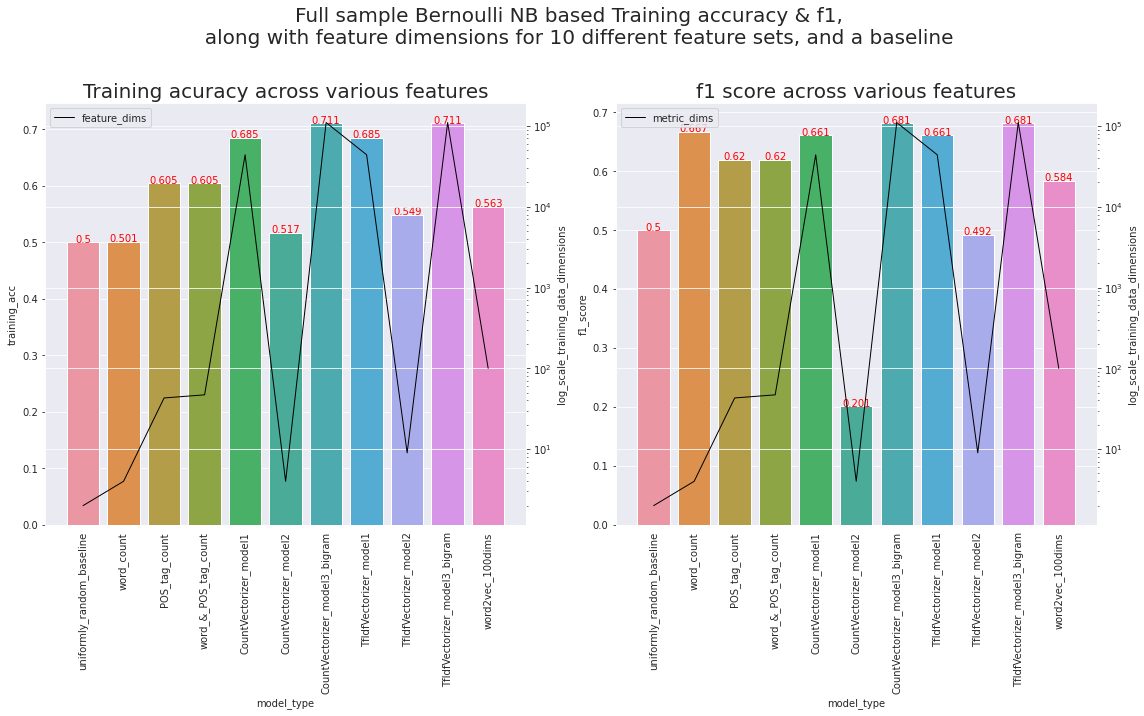

CPU times: user 17.9 s, sys: 1.33 s, total: 19.3 s
Wall time: 17.5 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  # Automated approach for basic naive bayes classifier

  X_Train_list=[X_train_wc1,X_train_wc2,X_train_wc3,
                wc_1[0],wc_2[0],wc_3[0],
                tfidf_1[0],tfidf_2[0],tfidf_3[0],
                X_train_w2v,
                # X_train_ner,
                # X_train_ner_aoa,
                ]
  X_dev_list=[X_dev_wc1,X_dev_wc2,X_dev_wc3,
              wc_1[1],wc_2[1],wc_3[1],
              tfidf_1[1],tfidf_2[1],tfidf_3[1],
              X_dev_w2v,
              # X_dev_ner,
              # X_dev_ner_aoa,
              ]

  # X_test_list=[X_test_wc1,X_test_wc2,X_test_wc3,
  #             wc_1[2],wc_2[2],wc_3[2],
  #             tfidf_1[2],tfidf_2[2],tfidf_3[2],
  #             X_test_w2v,
  #             # X_test_7 ,
  #             ]

  # model_defn=['word_count','POS_tag_count','word_&_POS_tag_count',
  #             "vect='CountVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True",
  #             "vect='CountVectorizer',min_df=10000,stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True",
  #             "vect='CountVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #             "vect='TfIdfVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True",
  #             "vect='TfIdfVectorizer',min_df=10000,stop_words=nu_stp_wrds,ngram_range=(1,1),lower_case=True",
  #             "vect='TfIdfVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #           'word2vec_100dims',
  #           'NER_feature',
  #           'NER_AoA_feature',
  #           ]

  model_defn=['word_count','POS_tag_count','word_&_POS_tag_count',
              "CountVectorizer_model1",
              "CountVectorizer_model2",
              "CountVectorizer_model3_bigram",
              "TfIdfVectorizer_model1",
              "TfIdfVectorizer_model2",
              "TfIdfVectorizer_model3_bigram",
            'word2vec_100dims',
            # 'NER_feature',
            # 'NER_AoA_feature',
            ]


  # NB Bernoulli based Training set accuracy and f1 score
  df=pd.DataFrame(columns=['model_type','dimensions','training_acc','training_f1',
                          'training_precision','training_recall'])
  df.at[0,'model_type']='uniformly_random_baseline'
  df.at[0,'dimensions']=X_dev_cv1.shape[1]
  df.at[0,'training_acc']=rand_train_acc
  df.at[0,'training_f1']=rand_train_f1
  df.at[0,'training_precision']=rand_train_precision
  df.at[0,'training_recall']=rand_train_recall

  # df.at[1,'model_type']='most_freq_baseline'
  # df.at[1,'dimensions']=X_dev_cv1.shape[1]
  # df.at[1,'training_acc']=mf_train_acc
  # df.at[1,'training_f1']=mf_train_f1
  # df.at[1,'training_precision']=mf_train_precision
  # df.at[1,'training_recall']=mf_train_recall

  print(df.head())

  nbclf=BernoulliNB() # for binary features
  for i in range(10):
    X_train=X_Train_list[i]
    X_dev=X_dev_list[i]
    model_name=model_defn[i]
    
    nbclf.fit(X_train[:,:],y_train[:])

    nb_train_preds=nbclf.predict(X_train)
    nb_train_acc=accuracy_score(y_train, nb_train_preds)
    nb_train_f1=f1_score(y_train, nb_train_preds)
    print(model_name,'\n labels available in predicted labels-->',set(nb_train_preds))
    nb_train_precision=precision_score(y_train, nb_train_preds)
    

    nb_train_recall=recall_score(y_train, nb_train_preds)

    df.at[i+1,'model_type']=model_name
    df.at[i+1,'dimensions']=X_train.shape[1]
    df.at[i+1,'training_acc']=nb_train_acc
    df.at[i+1,'training_f1']=nb_train_f1
    df.at[i+1,'training_precision']=nb_train_precision
    df.at[i+1,'training_recall']=nb_train_recall

  # print(df[['training_acc','training_f1']])

  # Plotting accuracy
  fig, (ax1, ax2)= plt.subplots(1, 2,sharex=True,figsize=(16,9))

  fig.suptitle('Full sample Bernoulli NB based Training accuracy & f1, \n\
  along with feature dimensions for 10 different feature sets, and a baseline',fontsize=20,x=0.5,y=1.1)

  sns.barplot(data=df, x='model_type', y='training_acc',ax=ax1)
  ax1.set_xticklabels(df['model_type'], rotation=90)
  # ax1.set_xlabel('model_type',fontsize=15)
  ax1.set_ylabel('training_acc',fontsize=10)
  ax1.set_title('Training acuracy across various features',fontsize=20)

  # Plotting the twin y axis for dimensions
  axes2 = ax1.twinx()
  axes2.set_yscale('log')
  line1=axes2.plot(df['model_type'],df['dimensions'],'black',linewidth=1,label="feature_dims")
  axes2.set_ylabel('log_scale_training_data_dimensions',fontsize=10)

  # Showing the labels in the barplot
  for index, row in df.iterrows():
    ax1.text(row.name,row.training_acc, round(row.training_acc,3), color='red', ha="center")

  plt.legend()

  sns.barplot(data=df, x='model_type', y='training_f1',ax=ax2)
  ax2.set_xticklabels(df['model_type'], rotation=90)
  ax2.set_xlabel('model_type',fontsize=10)
  ax2.set_ylabel('f1_score',fontsize=10)
  ax2.set_title('f1 score across various features',fontsize=20)

  # Plotting the twin y axis for dimensions
  axes2 = ax2.twinx()
  axes2.set_yscale('log')
  line1=axes2.plot(df['model_type'],df['dimensions'],'black',linewidth=1,label="metric_dims")
  axes2.set_ylabel('log_scale_training_data_dimensions',fontsize=10)

  # Showing the labels in the barplot
  for index, row in df.iterrows():
    ax2.text(row.name,row.training_f1, round(row.training_f1,3), color='red', ha="center")

  plt.legend()


  fig.tight_layout()
  plt.show()


  # Share x axis and plot f1 score in a similar fashion
  # Keep the 2nd y axis in log scale to show more granularity in the dimensions at the lower end 

INTERPRETATION

From the full sample Bernoulli NB classifier, highest accuracy and F1 score available for :
1. pos_tag_count
2. word-pos_tag_count
3. word_vector basic
4. word_vector_bigram
5. tfidf_vector basic
6. tfidf_vector_ngram
7. word2vec

The NeR and AoA based features do not perform that well -hence will not be pursued any further.

The reason that Word count has f1 score of 0 is due to an imbalance in the predicted labels (no label 1 available)

Thus, from both Logistic regression classifier and Bernoulli classifier we identify the following models to take forward:
1. word & pos tag count
2. pos tag count
3. count_vector bigram
4. tfidf_vector bigram

What about adding the word&pos tag count to count_vector bigram, tfidf_vector bigram and word2vec ?

Will combining features provide a better accuracy & precision on Bernoulli NB classifier than the individual feature sets?

Let's add word_POS_Tag_count features to the word_vector bigram, tfidf_vector bigram and word2vec features and check for training accuracy -on binomial classifier only

Need to convert the dense matrix of word & pos tag count matrix to sparse version and then concatenate.
As we cannot concatenate a dense and a sparse matrix and densifying the sparse matrix takes up a lot of memory.

Why not convert the available dense array to a sparse form and then combine these sparse matrix as feature representation ?

(300462, 110167) (300462, 47) (300462, 110214)
(300462, 110167) (300462, 47) (300462, 110214)
(300462, 100) (300462, 47) (300462, 147)
(46894, 110167) (46894, 47) (46894, 110214)
(46894, 110167) (46894, 47) (46894, 110214)
(46894, 100) (46894, 47) (46894, 147)
(119092, 110167) (119092, 47) (119092, 110214)
(119092, 110167) (119092, 47) (119092, 110214)
                  model_type dimensions  ... training_precision training_recall
0  uniformly_random_baseline          2  ...           0.500915        0.498103

[1 rows x 6 columns]
  training_acc training_f1
0     0.500047    0.499505
1     0.604526    0.619705
2     0.604526    0.619705
3     0.710629    0.681103
4     0.703407    0.690208
5     0.710629    0.681103
6     0.703407    0.690208
7      0.56267     0.58406
8     0.614274    0.635442


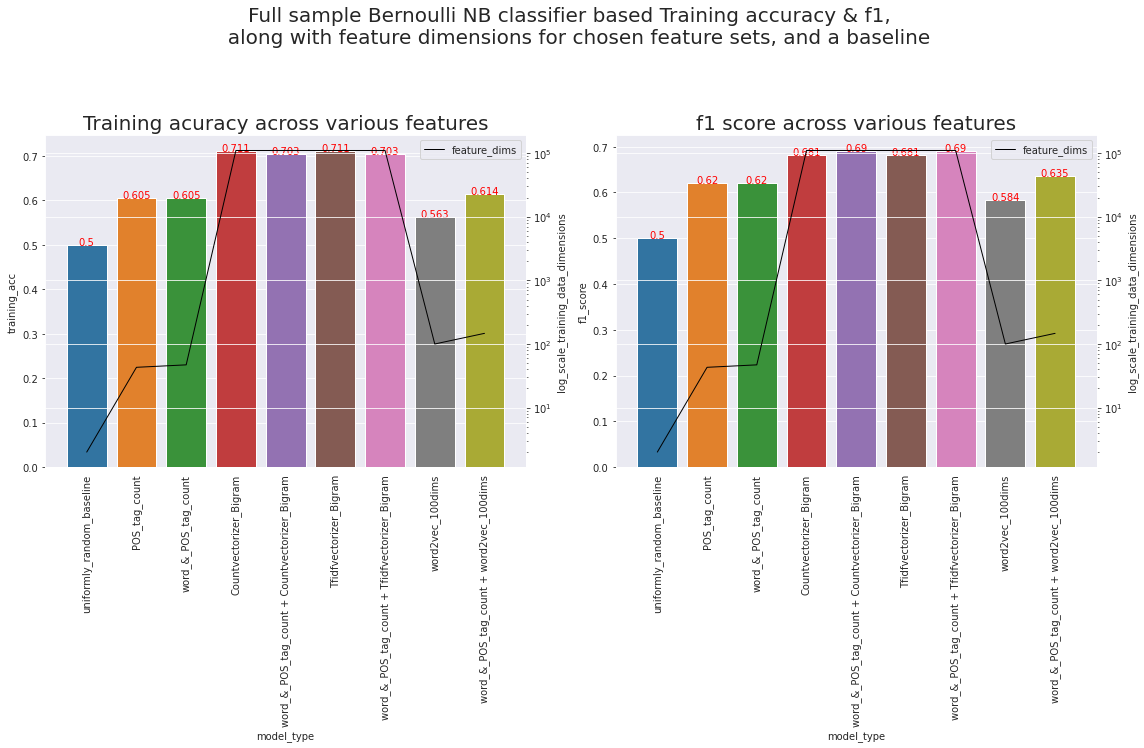

CPU times: user 20.7 s, sys: 1.83 s, total: 22.6 s
Wall time: 20.8 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  # Automated approach for basic logistic regression classifier
  # Adding the word & pos tag count matrix to the sparse matrix of word_vector & tfidf_vector


  # Converting dense matrix to sparse representation
  X_train_wc3_sparse=sparse.csr_matrix(X_train_wc3)
  X_dev_wc3_sparse=sparse.csr_matrix(X_dev_wc3)
  X_test_wc3_sparse=sparse.csr_matrix(X_test_wc3)
  X_train_w2v_sparse=sparse.csr_matrix(X_train_wc3)
  X_dev_w2v_sparse=sparse.csr_matrix(X_dev_wc3)


  # Combining the sparse matrix horizontally, this are created as coo sparse matrix and we need to 
  # convert them to csr matrix -to be usable in scikit_learn operations
  wc_3_0_combined=sparse.csr_matrix(sparse.hstack((wc_3[0],X_train_wc3_sparse)))
  tfidf_3_0_combined=sparse.csr_matrix(sparse.hstack((tfidf_3[0],X_train_wc3_sparse)))
  # Combining the dense matrix of word + pos tag count and w2v
  Xtrain_w2v_combined=np.hstack((X_train_w2v,X_train_wc3))

  wc_3_1_combined=sparse.csr_matrix(sparse.hstack((wc_3[1],X_dev_wc3_sparse)))
  tfidf_3_1_combined=sparse.csr_matrix(sparse.hstack((tfidf_3[1],X_dev_wc3_sparse)))
  # Combining the dense matrix of word + pos tag count and w2v
  Xdev_w2v_combined=np.hstack((X_dev_w2v,X_dev_wc3))


  wc_3_2_combined=sparse.csr_matrix(sparse.hstack((wc_3[2],X_test_wc3_sparse)))
  tfidf_3_2_combined=sparse.csr_matrix(sparse.hstack((tfidf_3[2],X_test_wc3_sparse)))
  # Combining the dense matrix of word + pos tag count and w2v
  Xtest_w2v_combined=np.hstack((X_test_w2v,X_test_wc3))

  # Checking the dimensions if they were combined properly
  print(wc_3[0].shape,X_train_wc3_sparse.shape,wc_3_0_combined.shape)
  print(tfidf_3[0].shape,X_train_wc3_sparse.shape,tfidf_3_0_combined.shape)
  print(X_train_w2v.shape,X_train_wc3.shape,Xtrain_w2v_combined.shape)


  print(wc_3[1].shape,X_dev_wc3_sparse.shape,wc_3_1_combined.shape)
  print(tfidf_3[1].shape,X_dev_wc3_sparse.shape,tfidf_3_1_combined.shape)
  print(X_dev_w2v.shape,X_dev_wc3.shape,Xdev_w2v_combined.shape)


  print(wc_3[2].shape,X_test_wc3_sparse.shape,wc_3_2_combined.shape)
  print(tfidf_3[2].shape,X_test_wc3_sparse.shape,tfidf_3_2_combined.shape)
  # print(X_test_w2v.shape,X_test_wc3.shape,Xtest_w2v_combined.shape)

  X_Train_list=[X_train_wc2,X_train_wc3,
                wc_3[0],
                wc_3_0_combined,
                tfidf_3[0],
                tfidf_3_0_combined,
                X_train_w2v,
                Xtrain_w2v_combined,
                # X_train_7,
                ]
  X_dev_list=[X_dev_wc2,X_dev_wc3,
              wc_3[1],
              wc_3_1_combined,
              tfidf_3[1],
              tfidf_3_1_combined,
              X_dev_w2v,
              Xdev_w2v_combined,
              # X_test_7,
              ]

  # model_defn=['POS_tag_count','word_&_POS_tag_count',
  #             "vect='CountVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #             "word_&_POS_tag_count + vect='CountVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #             "vect='TfIdfVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #             "word_&_POS_tag_count + vect='TfIdfVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #           'word2vec_100dims',
  #             'word_&_POS_tag_count + word2vec_100dims',
  #             '7th_Feature',
  #             ]


  model_defn=['POS_tag_count','word_&_POS_tag_count',
              "Countvectorizer_Bigram",
              "word_&_POS_tag_count + Countvectorizer_Bigram",
              "Tfidfvectorizer_Bigram",
              "word_&_POS_tag_count + Tfidfvectorizer_Bigram",
            'word2vec_100dims',
              'word_&_POS_tag_count + word2vec_100dims',
               ]

  # Logistic regression based Training set accuracy and f1 score
  df=pd.DataFrame(columns=['model_type','dimensions','training_acc','training_f1',
                          'training_precision','training_recall'])
  df.at[0,'model_type']='uniformly_random_baseline'
  df.at[0,'dimensions']=X_dev_cv1.shape[1]
  df.at[0,'training_acc']=rand_train_acc
  df.at[0,'training_f1']=rand_train_f1
  df.at[0,'training_precision']=rand_train_precision
  df.at[0,'training_recall']=rand_train_recall

  print(df.head())

  nbclf=BernoulliNB() # for binary features
  for i in range(8):
    X_train=X_Train_list[i]
    X_dev=X_dev_list[i]
    model_name=model_defn[i]
    
    nbclf.fit(X_train[:,:],y_train[:])

    nb_train_preds=nbclf.predict(X_train)
    nb_train_acc=accuracy_score(y_train, nb_train_preds)
    nb_train_f1=f1_score(y_train, nb_train_preds)
    nb_train_precision=precision_score(y_train, nb_train_preds)
    nb_train_recall=recall_score(y_train, nb_train_preds)

    df.at[i+1,'model_type']=model_name
    df.at[i+1,'dimensions']=X_train.shape[1]
    df.at[i+1,'training_acc']=nb_train_acc
    df.at[i+1,'training_f1']=nb_train_f1
    df.at[i+1,'training_precision']=nb_train_precision
    df.at[i+1,'training_recall']=nb_train_recall

  print(df[['training_acc','training_f1']])

  # Plotting accuracy
  fig, (ax1, ax2)= plt.subplots(1, 2,sharex=True,figsize=(16,9))

  fig.suptitle('Full sample Bernoulli NB classifier based Training accuracy & f1, \n\
  along with feature dimensions for chosen feature sets, and a baseline',
  fontsize=20,x=0.5,y=1.15)


  sns.barplot(data=df, x='model_type', y='training_acc',ax=ax1)
  ax1.set_xticklabels(df['model_type'], rotation=90)
  # ax1.set_xlabel('model_type',fontsize=15)
  ax1.set_ylabel('training_acc',fontsize=10)
  ax1.set_title('Training acuracy across various features',fontsize=20)

  # Plotting the twin y axis for dimensions
  axes2 = ax1.twinx()
  axes2.set_yscale('log')
  line1=axes2.plot(df['model_type'],df['dimensions'],'black',linewidth=1,label="feature_dims")
  axes2.set_ylabel('log_scale_training_data_dimensions',fontsize=10)

  # Showing the labels in the barplot
  for index, row in df.iterrows():
    ax1.text(row.name,row.training_acc, round(row.training_acc,3), color='red', ha="center")

  plt.legend()


  sns.barplot(data=df, x='model_type', y='training_f1',ax=ax2)
  ax2.set_xticklabels(df['model_type'], rotation=90)
  ax2.set_xlabel('model_type',fontsize=10)
  ax2.set_ylabel('f1_score',fontsize=10)
  ax2.set_title('f1 score across various features',fontsize=20)

  # Plotting the twin y axis for dimensions
  axes2 = ax2.twinx()
  axes2.set_yscale('log')
  line1=axes2.plot(df['model_type'],df['dimensions'],'black',linewidth=1,label="feature_dims")
  axes2.set_ylabel('log_scale_training_data_dimensions',fontsize=10)

  # Showing the labels in the barplot
  for index, row in df.iterrows():
    ax2.text(row.name,row.training_f1, round(row.training_f1,3), color='red', ha="center")

  plt.legend()

  fig.tight_layout()
  plt.show()




(300462, 110167) (300462, 47) (300462, 110214)
(300462, 110167) (300462, 47) (300462, 110214)
(300462, 100) (300462, 47) (300462, 147)
(46894, 110167) (46894, 47) (46894, 110214)
(46894, 110167) (46894, 47) (46894, 110214)
(46894, 100) (46894, 47) (46894, 147)
(119092, 110167) (119092, 47) (119092, 110214)
(119092, 110167) (119092, 47) (119092, 110214)
(300462, 110167) (300462, 110167) (300462, 220334)
(46894, 110167) (46894, 110167) (46894, 220334)
(119092, 110167) (119092, 110167) (119092, 220334)
0.6095662558109779 0.6247156004673377 {0, 1} {0, 1}
0.6095662558109779 0.6247156004673377 {0, 1} {0, 1}
0.6348999872051861 0.5929289807175633 {0, 1} {0, 1}
0.6495500490467864 0.6338072106600116 {0, 1} {0, 1}
0.6348999872051861 0.5929289807175633 {0, 1} {0, 1}
0.6495500490467864 0.6338072106600116 {0, 1} {0, 1}
0.5646351345587922 0.586887899635775 {0, 1} {0, 1}
0.6179468588732034 0.6388340120146757 {0, 1} {0, 1}
0.6347507143771058 0.5926366360652618 {0, 1} {0, 1}
0.6355184032072333 0.5987605

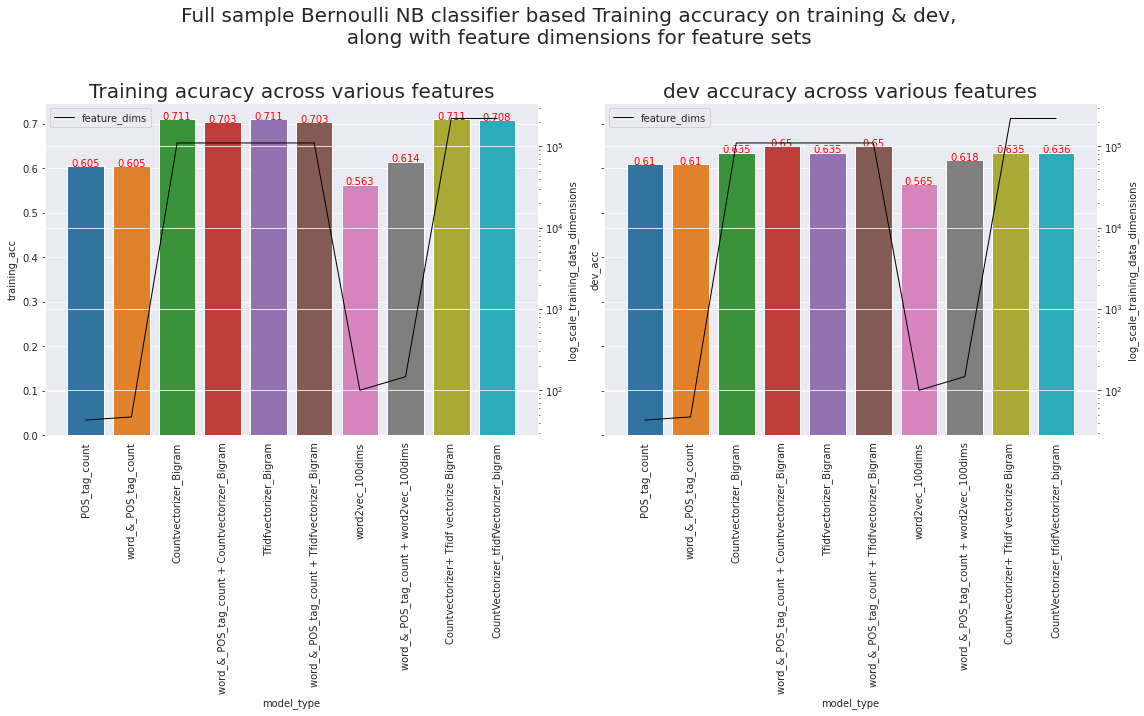

CPU times: user 23.1 s, sys: 3.23 s, total: 26.4 s
Wall time: 23.6 s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  # Automated approach for basic logistic regression classifier
  # Adding the word & pos tag count matrix to the sparse matrix of word_vector & tfidf_vector


  # Converting dense matrix to sparse representation
  X_train_wc3_sparse=sparse.csr_matrix(X_train_wc3)
  X_dev_wc3_sparse=sparse.csr_matrix(X_dev_wc3)
  X_test_wc3_sparse=sparse.csr_matrix(X_test_wc3)
  X_train_w2v_sparse=sparse.csr_matrix(X_train_w2v)
  X_dev_w2v_sparse=sparse.csr_matrix(X_dev_w2v)
  X_test_w2v_sparse=sparse.csr_matrix(X_test_w2v)


  # Combining the sparse matrix horizontally, this are created as coo sparse matrix and we need to 
  # convert them to csr matrix -to be usable in scikit_learn operations
  wc_3_0_combined=sparse.csr_matrix(sparse.hstack((wc_3[0],X_train_wc3_sparse)))
  tfidf_3_0_combined=sparse.csr_matrix(sparse.hstack((tfidf_3[0],X_train_wc3_sparse)))
  # Combining the dense matrix of word + pos tag count and w2v
  Xtrain_w2v_combined=np.hstack((X_train_w2v,X_train_wc3))

  wc_3_1_combined=sparse.csr_matrix(sparse.hstack((wc_3[1],X_dev_wc3_sparse)))
  tfidf_3_1_combined=sparse.csr_matrix(sparse.hstack((tfidf_3[1],X_dev_wc3_sparse)))
  # Combining the dense matrix of word + pos tag count and w2v
  Xdev_w2v_combined=np.hstack((X_dev_w2v,X_dev_wc3))


  wc_3_2_combined=sparse.csr_matrix(sparse.hstack((wc_3[2],X_test_wc3_sparse)))
  tfidf_3_2_combined=sparse.csr_matrix(sparse.hstack((tfidf_3[2],X_test_wc3_sparse)))
  # Combining the dense matrix of word + pos tag count and w2v
  Xtest_w2v_combined=np.hstack((X_test_w2v,X_test_wc3))

  # Combining the 2 sparse bigram arrays
  word_tfidf_bigram_train=sparse.csr_matrix(sparse.hstack((wc_3[0],tfidf_3[0])))
  word_tfidf_bigram_dev=sparse.csr_matrix(sparse.hstack((wc_3[1],tfidf_3[1])))
  word_tfidf_bigram_test=sparse.csr_matrix(sparse.hstack((wc_3[2],tfidf_3[2])))



  # Combining the 2 bigram arrays with word2vec 
  word_tfidf_bigram_w2v_train=sparse.csr_matrix(sparse.hstack((word_tfidf_bigram_train,
                                                              X_train_w2v_sparse)))
  
  word_tfidf_bigram_w2v_dev=sparse.csr_matrix(sparse.hstack((word_tfidf_bigram_dev,
                                                              X_dev_w2v_sparse)))
  
  word_tfidf_bigram_w2v_test=sparse.csr_matrix(sparse.hstack((word_tfidf_bigram_test,
                                                              X_test_w2v_sparse)))


  # Checking the dimensions if they were combined properly
  print(wc_3[0].shape,X_train_wc3_sparse.shape,wc_3_0_combined.shape)
  print(tfidf_3[0].shape,X_train_wc3_sparse.shape,tfidf_3_0_combined.shape)
  print(X_train_w2v.shape,X_train_wc3.shape,Xtrain_w2v_combined.shape)


  print(wc_3[1].shape,X_dev_wc3_sparse.shape,wc_3_1_combined.shape)
  print(tfidf_3[1].shape,X_dev_wc3_sparse.shape,tfidf_3_1_combined.shape)
  print(X_dev_w2v.shape,X_dev_wc3.shape,Xdev_w2v_combined.shape)


  print(wc_3[2].shape,X_test_wc3_sparse.shape,wc_3_2_combined.shape)
  print(tfidf_3[2].shape,X_test_wc3_sparse.shape,tfidf_3_2_combined.shape)
  # print(X_test_w2v.shape,X_test_wc3.shape,Xtest_w2v_combined.shape)

  print(wc_3[0].shape,tfidf_3[0].shape,word_tfidf_bigram_train.shape)
  print(wc_3[1].shape,tfidf_3[1].shape,word_tfidf_bigram_dev.shape)
  print(wc_3[2].shape,tfidf_3[2].shape,word_tfidf_bigram_test.shape)

  X_Train_list=[X_train_wc2,X_train_wc3,
                wc_3[0],
                wc_3_0_combined,
                tfidf_3[0],
                tfidf_3_0_combined,
                X_train_w2v,
                Xtrain_w2v_combined,
                word_tfidf_bigram_train,
                word_tfidf_bigram_w2v_train
                ]
  X_dev_list=[X_dev_wc2,X_dev_wc3,
              wc_3[1],
              wc_3_1_combined,
              tfidf_3[1],
              tfidf_3_1_combined,
              X_dev_w2v,
              Xdev_w2v_combined,
              word_tfidf_bigram_dev,
              word_tfidf_bigram_w2v_dev
              ]

  # model_defn=['POS_tag_count','word_&_POS_tag_count',
  #             "vect='CountVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #             "word_&_POS_tag_count + vect='CountVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #             "vect='TfIdfVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #             "word_&_POS_tag_count + vect='TfIdfVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #           'word2vec_100dims',
  #             'word_&_POS_tag_count + word2vec_100dims',
  #             '7th_Feature',
  #             ]


  model_defn=['POS_tag_count','word_&_POS_tag_count',
              "Countvectorizer_Bigram",
              "word_&_POS_tag_count + Countvectorizer_Bigram",
              "Tfidfvectorizer_Bigram",
              "word_&_POS_tag_count + Tfidfvectorizer_Bigram",
            'word2vec_100dims',
              'word_&_POS_tag_count + word2vec_100dims',
              'Countvectorizer+ Tfidf vectorize Bigram',
              'CountVectorizer_tfidfVectorizer_bigram',
              'CountVectorizer_tfidfVectorizer_bigram_w2v'
               ]

  

  # Benoulli NB based Training set accuracy and f1 score
  df=pd.DataFrame(columns=['model_type','dimensions','training_acc','training_f1',
                          'dev_accuracy','dev_f1'])

  nbclf=BernoulliNB() # for binary features
  for i in range(10):
    X_train=X_Train_list[i]
    X_dev=X_dev_list[i]
    model_name=model_defn[i]
    
    nbclf.fit(X_train,y_train)

    nb_train_preds=nbclf.predict(X_train)
    nb_train_acc=accuracy_score(y_train, nb_train_preds)
    # print('y_train.shape -->',len(y_train),'nb_train_preds.shape -->', nb_train_preds.shape)
    nb_train_f1=f1_score(y_train, nb_train_preds)

    nb_dev_preds=nbclf.predict(X_dev)
    nb_dev_acc=accuracy_score(y_dev, nb_dev_preds)
    # print('y_dev.shape -->',len(y_dev),'nb_dev_preds.shape -->', nb_dev_preds.shape)
    nb_dev_f1=f1_score(y_dev, nb_dev_preds)
    print(nb_dev_acc,nb_dev_f1,set(y_dev),set(nb_dev_preds))
    

    df.at[i,'model_type']=model_name
    df.at[i,'dimensions']=X_train.shape[1]
    df.at[i,'training_acc']=nb_train_acc
    df.at[i,'training_f1']=nb_train_f1
    df.at[i,'dev_acc']=nb_dev_acc
    df.at[i,'dev_f1']=nb_dev_f1
    

  # print(df[['training_acc','training_f1','dev_acc','dev_f1']])

  # Plotting accuracy
  fig, (ax1, ax2)= plt.subplots(1, 2,sharey=True,figsize=(16,9))

  fig.suptitle('Full sample Bernoulli NB classifier based Training accuracy on training & dev, \n\
  along with feature dimensions for feature sets',fontsize=20,x=0.5,y=1.1)


  sns.barplot(data=df, x='model_type', y='training_acc',ax=ax1)
  ax1.set_xticklabels(df['model_type'], rotation=90)
  # ax1.set_xlabel('model_type',fontsize=15)
  ax1.set_ylabel('training_acc',fontsize=10)
  ax1.set_title('Training acuracy across various features',fontsize=20)

  # Plotting the twin y axis for dimensions
  axes2 = ax1.twinx()
  axes2.set_yscale('log')
  line1=axes2.plot(df['model_type'],df['dimensions'],'black',linewidth=1,label="feature_dims")
  axes2.set_ylabel('log_scale_training_data_dimensions',fontsize=10)

  # Showing the labels in the barplot
  for index, row in df.iterrows():
    ax1.text(row.name,row.training_acc, round(row.training_acc,3), color='red', ha="center")

  plt.legend()

  sns.barplot(data=df, x='model_type', y='dev_acc',ax=ax2)
  ax2.set_xticklabels(df['model_type'], rotation=90)
  ax2.set_xlabel('model_type',fontsize=10)
  ax2.set_ylabel('dev_acc',fontsize=10)
  ax2.set_title('dev accuracy across various features',fontsize=20)

  # Plotting the twin y axis for dimensions
  axes2 = ax2.twinx()
  axes2.set_yscale('log')
  line1=axes2.plot(df['model_type'],df['dimensions'],'black',linewidth=1,label="feature_dims")
  axes2.set_ylabel('log_scale_training_data_dimensions',fontsize=10)

  # Showing the labels in the barplot
  for index, row in df.iterrows():
    ax2.text(row.name,row.dev_acc, round(row.dev_acc,3), color='red', ha="center")

  print(df)

  plt.legend()

  fig.tight_layout()
  plt.show()



INTERPRETATION

On Training accuracy & f1, the following combined features do seem to perform marginally well
1. word-pos_tag_count + word_vector_bigram
2. word-pos_tag_count + tfidf_vector_ngram

May be they will perform better on a Logistic Classifier -which we will evaluate next .



Hence, we will include these features along with the 4 original features and save them as features in a pickle object.

# 9.Final Feature selection and saving as pickle object.

From the features selected from Logistic Regression classification Accuracy and Naive Bayes Accuracy, we will further reduce them using Validation accuracy on full sample using Naive Bayes (for faster processing)

The final features will be saved as a pickle object to be used in later part of the Project pipeline.

Running the Training and validation accuracy on full sample for the 5 chosen features

0.6318718812641276 0.606361874358682 {0, 1} {0, 1}
0.6468418134516143 0.627449216025915 {0, 1} {0, 1}
0.6310402183648228 0.6140530894490296 {0, 1} {0, 1}
0.6542414807864546 0.6406949430483534 {0, 1} {0, 1}
0.625410500277221 0.6234027956435982 {0, 1} {0, 1}
0.6740094681622383 0.6625609783016578 {0, 1} {0, 1}
0.5767902077024779 0.5901111157007723 {0, 1} {0, 1}
0.654476052373438 0.6462922133205264 {0, 1} {0, 1}
  training_acc training_f1   dev_acc    dev_f1
0     0.628179    0.602874  0.631872  0.606362
1     0.641728    0.621732  0.646842  0.627449
2     0.676731    0.663877  0.631040  0.614053
3     0.692969     0.68278  0.654241  0.640695
4      0.65616    0.651977  0.625411  0.623403
5     0.691911    0.682211  0.674009  0.662561
6     0.578143    0.589648  0.576790  0.590111
7     0.651573    0.643108  0.654476  0.646292
                                      model_type dimensions  ...    dev_f1   dev_acc
0                                  POS_tag_count         43  ...  0.606362  0.63

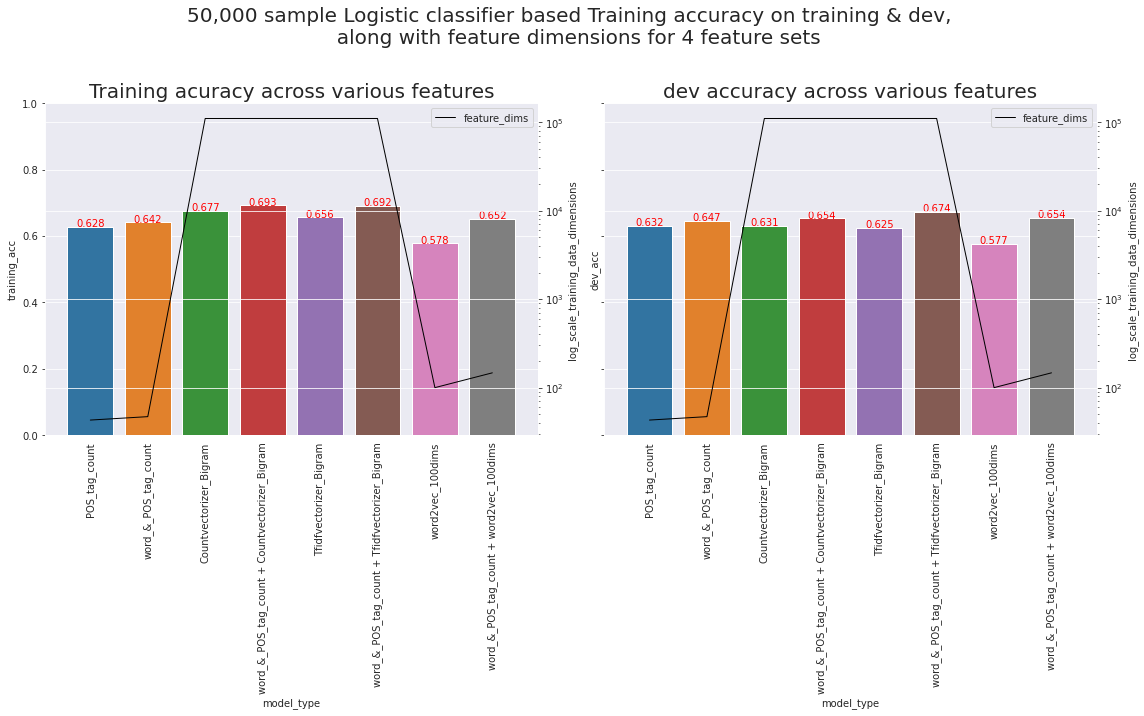

CPU times: user 11min 14s, sys: 11min 45s, total: 22min 59s
Wall time: 11min 45s


In [ ]:
%%time

with joblib.parallel_backend('dask'):
  # Automated approach for basic Logistic classifier on full sample for chosen 4 fetaure sets

  X_Train_list=[X_train_wc2,X_train_wc3,
                wc_3[0],
                wc_3_0_combined,
                tfidf_3[0],
                tfidf_3_0_combined,
                X_train_w2v,
                Xtrain_w2v_combined,
                # X_train_7,
                ]
  X_dev_list=[X_dev_wc2,X_dev_wc3,
              wc_3[1],
              wc_3_1_combined,
              tfidf_3[1],
              tfidf_3_1_combined,
              X_dev_w2v,
              Xdev_w2v_combined,
              # X_test_7,
              ]

  # model_defn=['POS_tag_count','word_&_POS_tag_count',
  #             "vect='CountVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #             "word_&_POS_tag_count + vect='CountVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #             "vect='TfIdfVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #             "word_&_POS_tag_count + vect='TfIdfVectorizer',min_df=5,stop_words=nu_stp_wrds,ngram_range=(1,2),lower_case=True",
  #           'word2vec_100dims',
  #             'word_&_POS_tag_count + word2vec_100dims',
  #             '7th_Feature',
  #             ]


  model_defn=['POS_tag_count','word_&_POS_tag_count',
              "Countvectorizer_Bigram",
              "word_&_POS_tag_count + Countvectorizer_Bigram",
              "Tfidfvectorizer_Bigram",
              "word_&_POS_tag_count + Tfidfvectorizer_Bigram",
            'word2vec_100dims',
              'word_&_POS_tag_count + word2vec_100dims',
               ]

  # Logistc Classifier based Training set accuracy and f1 score
  df=pd.DataFrame(columns=['model_type','dimensions','training_acc','training_f1',
                          'dev_accuracy','dev_f1'])

  clf=LogisticRegression(random_state=RANDOM_SEED,solver='lbfgs',max_iter=30000)
  for i in range(8):
    X_train=X_Train_list[i]
    X_dev=X_dev_list[i]
    model_name=model_defn[i]
    
    clf.fit(X_train[:50000,],y_train[:50000])

    nb_train_preds=clf.predict(X_train)
    nb_train_acc=accuracy_score(y_train, nb_train_preds)
    # print('y_train.shape -->',len(y_train),'nb_train_preds.shape -->', nb_train_preds.shape)
    nb_train_f1=f1_score(y_train, nb_train_preds)

    nb_dev_preds=clf.predict(X_dev)
    nb_dev_acc=accuracy_score(y_dev, nb_dev_preds)
    # print('y_dev.shape -->',len(y_dev),'nb_dev_preds.shape -->', nb_dev_preds.shape)
    nb_dev_f1=f1_score(y_dev, nb_dev_preds)
    print(nb_dev_acc,nb_dev_f1,set(y_dev),set(nb_dev_preds))
    

    df.at[i,'model_type']=model_name
    df.at[i,'dimensions']=X_train.shape[1]
    df.at[i,'training_acc']=nb_train_acc
    df.at[i,'training_f1']=nb_train_f1
    df.at[i,'dev_acc']=nb_dev_acc
    df.at[i,'dev_f1']=nb_dev_f1
    

  print(df[['training_acc','training_f1','dev_acc','dev_f1']])

  # Plotting accuracy
  fig, (ax1, ax2)= plt.subplots(1, 2,sharey=True,figsize=(16,9))

  fig.suptitle('50,000 sample Logistic classifier based Training accuracy on training & dev, \n\
  along with feature dimensions for 4 feature sets',fontsize=20,x=0.5,y=1.1)


  sns.barplot(data=df, x='model_type', y='training_acc',ax=ax1)
  ax1.set_xticklabels(df['model_type'], rotation=90)
  # ax1.set_xlabel('model_type',fontsize=15)
  ax1.set_ylabel('training_acc',fontsize=10)
  ax1.set_title('Training acuracy across various features',fontsize=20)
  ax1.set_ylim(0, 1)

  # Plotting the twin y axis for dimensions
  axes2 = ax1.twinx()
  axes2.set_yscale('log')
  line1=axes2.plot(df['model_type'],df['dimensions'],'black',linewidth=1,label="feature_dims")
  axes2.set_ylabel('log_scale_training_data_dimensions',fontsize=10)

  # Showing the labels in the barplot
  for index, row in df.iterrows():
    ax1.text(row.name,row.training_acc, round(row.training_acc,3), color='red', ha="center")

  plt.legend()

  sns.barplot(data=df, x='model_type', y='dev_acc',ax=ax2)
  ax2.set_xticklabels(df['model_type'], rotation=90)
  ax2.set_xlabel('model_type',fontsize=10)
  ax2.set_ylabel('dev_acc',fontsize=10)
  ax2.set_title('dev accuracy across various features',fontsize=20)

  # Plotting the twin y axis for dimensions
  axes2 = ax2.twinx()
  axes2.set_yscale('log')
  line1=axes2.plot(df['model_type'],df['dimensions'],'black',linewidth=1,label="feature_dims")
  axes2.set_ylabel('log_scale_training_data_dimensions',fontsize=10)

  # Showing the labels in the barplot
  for index, row in df.iterrows():
    ax2.text(row.name,row.dev_acc, round(row.dev_acc,3), color='red', ha="center")

  plt.legend()

  print(df)

  fig.tight_layout()
  plt.show()




INTERPRETATION

From the training and validation accuracy on full sample, the features which seem to be performing the best are :
1. word-pos_tag_count + tfidf_vector_bigram
2. word-pos_tag_count + tfidf_vector_bigram

However the other  features are quite close to each other hence we will save all of these features -especially the original versions of the combined features above.

We will now save the training and dev features for these models as a pickle object-to be used in later part of the pipeline

Saving selected train and dev sets of top 2 features, and other key files as pickle object



In [ ]:
# # save to pickle object
pkl_dict={'y_train':y_train,
          'y_dev':y_dev,
          'y_test':y_test,

          'word_vector_X_train':wc_3[0],
          'tfidf_vector_X_train':tfidf_3[0],
          'combined_word_vector_X_train':wc_3_0_combined,
          'combined_tfidf_vector_X_train':tfidf_3_0_combined,
          'combined_w2v_X_train':Xtrain_w2v_combined,
           'pos_tag_count_X_train':X_train_wc2,
            'word_pos_tag_count_X_train':X_train_wc3,
          'w2v_X_train':X_train_w2v,

          'word_vector_X_dev':wc_3[1],
          'tfidf_vector_X_dev':tfidf_3[1],
          'combined_word_vector_X_dev':wc_3_1_combined,
          'combined_tfidf_vector_X_dev':tfidf_3_1_combined,
          'combined_w2v_X_dev':Xdev_w2v_combined,
              'pos_tag_count_X_dev':X_dev_wc2,
              'word_pos_tag_count_X_dev':X_dev_wc3,
          'w2v_X_dev':X_dev_w2v,

          'word_vector_X_test':wc_3[2],
          'tfidf_vector_X_test':tfidf_3[2],
          'combined_word_vector_X_test':wc_3_2_combined,
          'combined_tfidf_vector_X_test':tfidf_3_2_combined,
          'combined_w2v_X_test':Xtest_w2v_combined,
          'pos_tag_count_X_test':X_test_wc2,
          'word_pos_tag_count_X_test':X_test_wc3,
          'w2v_X_test':X_test_w2v,


           'New_Training_df':train_df_new,'dev_df':dev_df,'test_df':test_df_1,
          
          }

pickle_out = open("/content/drive/Shareddrives/MADS_Milestone2_Drive/Data/pkl_dict.pickle","wb")
pickle.dump(pkl_dict, pickle_out)
pickle_out.close()

# 10.Save dependencies

In [ ]:
# Dependencies
# providing watermark
!pip install watermark
%reload_ext watermark
%watermark
%watermark --iversions

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.1
    Uninstalling importlib-metadata-4.8.1:
      Successfully uninstalled importlib-metadata-4.8.1
Last updated: 2021-09-26T12:54:39.377151+00:00

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

re        : 2.2.1
scipy     : 1.4.1
joblib    : 1.0.1
seaborn   : 0.11.2
numpy     : 1.19.5
IPython   : 5.5.0
gensim    : 3.6.0
sklearn   : 0.0
matplotlib: 3.2.2
pandas    : 1.1.5
nltk      : 3.2.5
google    : 2.0.3

